In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import matplotlib
import ipyparams

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib_dev_optControl.neurolib.models.aln import ALNModel
from neurolib_dev_optControl.neurolib.utils import plotFunctions as plotFunc
from neurolib_dev_optControl.neurolib.utils import func_optimize as fo
from neurolib_dev_optControl.neurolib.utils import costFunctions as cost
import neurolib_dev_optControl.neurolib.dashboard.functions as functions
import neurolib_dev_optControl.neurolib.dashboard.data as data
import neurolib_dev_optControl.neurolib.dashboard.layout as layout
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

cmap_ = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors_rgba()
exc_red = cmap_(3)
inh_blue=cmap_(0)
green = cmap_(2)

<IPython.core.display.Javascript object>

In [2]:
aln = ALNModel()
N = aln.params.N

aln.params.sigma_ou = 0.
aln.params.mue_ext_mean = 0.
aln.params.mui_ext_mean = 0.
aln.params.ext_exc_current = 0.
aln.params.ext_inh_current = 0.

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

def rep_ind(c0, c1):
    abs_diff = np.abs(c0-c1)
    res = 0.
    for n in range(c0.shape[0]):
        for v in range(c0.shape[1]):
            res += sum(abs_diff[n,v,:]) * dt
            
    return res

In [3]:
points = np.array( [ [0.86, 0.25] ])

# 10 points, two costs, 4 methods, N 

In [4]:
def create_dict(task, point, cost_params, init, init_vars, target, sigma_array, N_max_array, it_array):
    return dict( {'task':task, 'point':point, 'cost_params':cost_params, 'init':init, 'init_vars':init_vars,
            'target':target, 'sigma':sigma_array, 'N_array':N_max_array, 'it_array':it_array,
            'cost':np.zeros(( len(sigma_array), 4, 2, len(N_max_array), len(it_array) )),
            'rep_ind':np.zeros(( len(sigma_array), 4, 2, len(N_max_array), len(it_array) ))     } )

params_list = ['task', 'point', 'cost_params', 'init', 'init_vars', 'target', 'sigma', 'N_array',
               'cost', 'rep_ind']

In [5]:
dict_list = []
sigma_array = np.arange(0.01, 0.081, 0.02)
N_array = [2,10,30,50]
it_array = np.arange(0,25,6)

for p in points:
    dict_list.append(create_dict('DU', p, [None]*len(sigma_array), [1], None,
                [None]*len(sigma_array), sigma_array, N_array, it_array) )

In [8]:
for d in dict_list:
    print(d['target'])

[array([[[ 2.97505332,  2.97505332,  2.97505332, ...,  2.97505332,
          2.97505332,  2.97505332],
        [14.96827659, 14.96827659, 14.96827659, ..., 14.96827659,
         14.96827659, 14.96827659]]]), array([[[ 2.97505332,  2.97505332,  2.97505332, ...,  2.97505332,
          2.97505332,  2.97505332],
        [14.96827659, 14.96827659, 14.96827659, ..., 14.96827659,
         14.96827659, 14.96827659]]]), array([[[ 2.97505332,  2.97505332,  2.97505332, ...,  2.97505332,
          2.97505332,  2.97505332],
        [14.96827659, 14.96827659, 14.96827659, ..., 14.96827659,
         14.96827659, 14.96827659]]]), array([[[ 2.97505332,  2.97505332,  2.97505332, ...,  2.97505332,
          2.97505332,  2.97505332],
        [14.96827659, 14.96827659, 14.96827659, ..., 14.96827659,
         14.96827659, 14.96827659]]])]


In [7]:
dict_file = "UD_1I.pickle"

if False:
    file=open(dict_file, "wb")
    pickle.dump(dict_list, file)
    file.close()

if True:
    file = open(dict_file, "rb")
    dict_list = pickle.load(file)
    file.close()

In [9]:
dur_pre = 10
dur_post = 10
dur = 500.
dur_comp = 2000.
dt = aln.params.dt
T = int(1 + dur / dt)

prec_vars = [0,1]
trans_time = 0.6

n_pre = int(np.around(dur_pre/aln.params.dt,1))
n_post = int(np.around(dur_post/aln.params.dt,1))

tol = 1e-16
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

maxC = [5., -5., 0.18, 0.]
n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

noise_realizations_final = 10000
dur_target_compute = 100000
init_it = 3

Point =  [0.86 0.25]


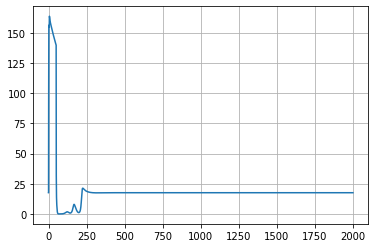

In [15]:
# get init vars without noise
aln.params.duration = dur_comp

# initial without noise
control0 = aln.getZeroControl()

for d in dict_list:
    
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    aln.params.duration = dur_comp
    aln.params.sigma_ou = 0.
    
    control0[0,0,:500] = 5.

    aln.run(control=control0)

    plt.plot(aln.t, aln.rates_exc[0,:])
    plt.show() 

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars = init_state_vars.copy()
    d['init_vars'] = initVars

Point =  [0.86 0.25]


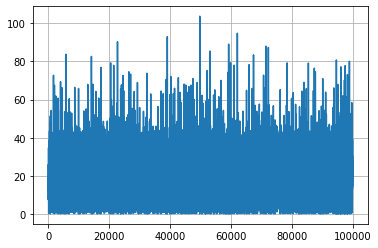

[ 2.97505332 14.96827659]
0.000453543417133211


In [16]:
for d in dict_list:
    
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
        
    aln.params.sigma_ou = 0.15
    aln.params.duration = dur_target_compute

    setinit(d['init_vars'], aln)

    target_rates_e = []
    target_rates_i = []

    aln.run(control=aln.getZeroControl())
    for t in range(len(aln.t)):
        if aln.rates_exc[0,t] > 10.:
            continue
        if aln.rates_inh[0,t] > 30.:
            continue

        target_rates_e.append(aln.rates_exc[0,t])
        target_rates_i.append(aln.rates_inh[0,t])

    plt.plot(aln.t, aln.rates_exc[0,:])
    #plt.plot(aln.t, aln.rates_inh[0,:])
    plt.show()            

    aln.params.duration = dur
    target = aln.getZeroTarget()
    target[:,0,:] = np.mean(target_rates_e)
    target[:,1,:] = np.mean(target_rates_i)
    stddev = np.std(target_rates_e) + np.std(target_rates_i)
        
    for ind_s in range(len(d['sigma'])): 
        
        d['target'][ind_s] = target
        d['cost_params'][ind_s] = [1. / ( stddev * (1. - trans_time) * dur ), 0., 1.]
        
        
    print(d['target'][0][0,:,-1])
    print(d['cost_params'][0][0])
        
    file=open(dict_file, "wb")
    pickle.dump(dict_list, file)
    file.close()
    
    

In [10]:
#len(sigma_array), 4, N_max, max_it

##### METHOD 1
method_ind = 0
step_method_ind = 0

for d in dict_list:
        
        
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    
    max_it = d['cost'].shape[3]
    
    for s_ind in range(len(d['sigma'])):
        
        print("sigma = ", d['sigma'][s_ind])
        
        s = d['sigma'][s_ind]
        aln.params.sigma_ou = s
        c_p = d['cost_params'][s_ind]
        cost.setParams(c_p[0], c_p[1], c_p[2])
        aln.params.duration = dur
        zero_init = aln.getZeroControl()
        
        target_ = d['target'][s_ind].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
        
        if np.amin(d['cost'][s_ind, method_ind, step_method_ind, :, 0]) == 0.:
        
            setinit(d['init_vars'], aln)
            cost_final = 0.

            for n_ in range(noise_realizations_final):
                state_ = fo.updateState(aln, zero_init)
                cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                               state_, target_, list(prec_vars) )

            d['cost'][s_ind, :, :, :, 0] = cost_final/noise_realizations_final
            
        print('cost = ', d['cost'][s_ind, 0, 0, 0])    
        
        for i_it in range(1,len(d['it_array'])):
            
            it = d['it_array'][i_it]
            print("iteration = ", it)
        
            for n_ind in range(len(d['N_array'])):

                if ( d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0.
                    and d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0. ) :
                    continue
                    
                n_max = d['N_array'][n_ind]
                print("n max = ", n_max)

                aln.params.duration = dur
                     
                    
                n_ = 0
                control_sum = aln.getZeroControl()
                
                while n_ < n_max:
                
                    print('--------', n_)

                    aln.params.duration = dur
                    control_init = aln.getZeroControl()               
                    setinit(d['init_vars'], aln)
                    
                    c_vars = d['init']

                    bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                        control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                        control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                        noise_real=0, init_params = d['init_vars'])
                    
                    if np.isnan(c_).any():
                        continue
                    
                    control_init = bc[:,:,n_pre:-n_post]
                    c_vars = [0,1]
                    aln.params.duration = dur
                    setinit(d['init_vars'], aln)
                    
                    bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                        control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = it-init_it,
                        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                        control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                        noise_real=0, init_params = d['init_vars'])
                    
                    if np.isnan(c_).any():
                        continue
                    
                    control_sum += bc[:,:,n_pre:-n_post]
                    n_ += 1

                control_init = control_sum / n_max
        
                aln.params.duration = dur
                setinit(d['init_vars'], aln)

                cost_final = 0.

                for j in range(noise_realizations_final):
                    state_ = fo.updateState(aln, control_init)
                    cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                                   state_, target_, list(prec_vars) )
                    cost_final += cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2],
                                                                   dt, control_init)

                d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] = cost_final/noise_realizations_final
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                ###############################################################
                
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                     
                    
                n_ = 0
                control_sum = aln.getZeroControl()
                
                while n_ < n_max:
                
                    print('--------', n_)

                    aln.params.duration = dur
                    control_init1 = aln.getZeroControl()               
                    setinit(d['init_vars'], aln)
                    
                    c_vars = d['init']

                    bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                        control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                        control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                        noise_real=0, init_params = d['init_vars'])
                    
                    if np.isnan(c_).any():
                        continue
                    
                    control_init1 = bc[:,:,n_pre:-n_post]
                    c_vars = [0,1]
                    aln.params.duration = dur
                    setinit(d['init_vars'], aln)
                    
                    bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                        control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = it-init_it,
                        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                        control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                        noise_real=0, init_params = d['init_vars'])
                    
                    if np.isnan(c_).any():
                        continue
                    
                    control_sum += bc[:,:,n_pre:-n_post]
                    n_ += 1

                control_init1 = control_sum / n_max
                
                d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] = rep_ind(control_init, control_init1)
                print('rep_ind = ', d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                file=open(dict_file, "wb")
                pickle.dump(dict_list, file)
                file.close()

Point =  [0.86 0.25]
sigma =  0.01
set cost params:  0.000453543417133211 0.0 1.0
cost =  [63.50717341 19.58846898 13.41275118 14.20713236 13.13565268]
iteration =  6
iteration =  12
iteration =  18
iteration =  24
sigma =  0.03
set cost params:  0.000453543417133211 0.0 1.0
cost =  [63.08083058 17.39429962 16.67229775 14.56862369 15.9052819 ]
iteration =  6
iteration =  12
iteration =  18
iteration =  24
sigma =  0.049999999999999996
set cost params:  0.000453543417133211 0.0 1.0
cost =  [62.20837301 18.59091536 31.35564723 22.42278826 18.60044856]
iteration =  6
iteration =  12
iteration =  18
iteration =  24
sigma =  0.06999999999999999
set cost params:  0.000453543417133211 0.0 1.0
cost =  [61.58510386 22.20155819 25.40282428 23.42719033  0.        ]
iteration =  6
iteration =  12
iteration =  18
n max =  50
-------- 0
interpolate adjoint :  True True True
initial cost =  69.70892692877132
RUN  0 , total integrated cost =  69.70892692877132
Gradient descend method:  None
RUN  1 , t

RUN  11 , total integrated cost =  14.805674850234357
RUN  12 , total integrated cost =  16.259539041521805
RUN  13 , total integrated cost =  15.806126611521524
RUN  14 , total integrated cost =  15.897516544001643
RUN  15 , total integrated cost =  17.633014269028003
RUN  15 , total integrated cost =  17.633014269028003
Improved over  15  iterations in  3.161948940000002  seconds by  25.431355578282563  percent.
-------- 5
interpolate adjoint :  True True True
initial cost =  58.82386734451714
RUN  0 , total integrated cost =  58.82386734451714
Gradient descend method:  None
RUN  1 , total integrated cost =  47.57748991512873
RUN  2 , total integrated cost =  40.110859900839856
RUN  3 , total integrated cost =  33.87032896981033
RUN  3 , total integrated cost =  33.87032896981033
Improved over  3  iterations in  0.32812096800012114  seconds by  42.42077153574413  percent.
interpolate adjoint :  True True True
initial cost =  45.467580746165
RUN  0 , total integrated cost =  45.467580

RUN  2 , total integrated cost =  28.342295915559273
RUN  3 , total integrated cost =  27.053585399029146
RUN  3 , total integrated cost =  27.053585399029146
Improved over  3  iterations in  0.3078198909997809  seconds by  61.70195323121087  percent.
interpolate adjoint :  True True True
initial cost =  30.1048696093672
RUN  0 , total integrated cost =  30.1048696093672
Gradient descend method:  None
RUN  1 , total integrated cost =  20.55183203679786
RUN  2 , total integrated cost =  20.528750108728822
RUN  3 , total integrated cost =  19.93748001719247
RUN  4 , total integrated cost =  20.031888227302577
RUN  5 , total integrated cost =  19.696387717808367
RUN  6 , total integrated cost =  19.321817672326695
RUN  7 , total integrated cost =  19.080692313767212
RUN  8 , total integrated cost =  19.802590928244175
RUN  9 , total integrated cost =  19.751798772634928
RUN  10 , total integrated cost =  18.811862842515232
RUN  11 , total integrated cost =  19.941419729147608
RUN  12 , to

RUN  1 , total integrated cost =  16.279097477626085
RUN  2 , total integrated cost =  15.68797750822909
RUN  3 , total integrated cost =  16.05636106373825
RUN  4 , total integrated cost =  16.67275345578222
RUN  5 , total integrated cost =  16.655761804996068
RUN  6 , total integrated cost =  16.326057898991163
RUN  7 , total integrated cost =  16.115583882876013
RUN  8 , total integrated cost =  16.290119914359185
RUN  9 , total integrated cost =  17.027695190623056
RUN  10 , total integrated cost =  16.225116292069345
RUN  11 , total integrated cost =  16.545323534447373
RUN  12 , total integrated cost =  16.34759315690182
RUN  13 , total integrated cost =  16.626489531191208
RUN  14 , total integrated cost =  16.59455003175578
RUN  15 , total integrated cost =  16.80063527523217
RUN  15 , total integrated cost =  16.80063527523217
Improved over  15  iterations in  2.6180361239999  seconds by  6.082212277128136  percent.
-------- 16
interpolate adjoint :  True True True
initial cos

RUN  9 , total integrated cost =  15.476460588482881
RUN  10 , total integrated cost =  16.49615590268572
RUN  11 , total integrated cost =  20.816344343452883
RUN  12 , total integrated cost =  15.770732875818979
RUN  13 , total integrated cost =  17.76045254844844
RUN  14 , total integrated cost =  17.743743154476576
RUN  15 , total integrated cost =  20.24287484411176
RUN  15 , total integrated cost =  20.24287484411176
Improved over  15  iterations in  2.730417713999941  seconds by  42.72347467221639  percent.
-------- 21
interpolate adjoint :  True True True
initial cost =  62.20555135181174
RUN  0 , total integrated cost =  62.20555135181174
Gradient descend method:  None
RUN  1 , total integrated cost =  45.158988483691566
RUN  2 , total integrated cost =  36.54008597617475
RUN  3 , total integrated cost =  31.97978811424497
Control only changes marginally.
RUN  3 , total integrated cost =  31.97978811424497
Improved over  3  iterations in  0.37543649500003085  seconds by  48.59

initial cost =  60.55566546200664
RUN  0 , total integrated cost =  60.55566546200664
Gradient descend method:  None
RUN  1 , total integrated cost =  32.06622255877826
RUN  2 , total integrated cost =  28.557240423461632
RUN  3 , total integrated cost =  29.630858594138335
RUN  3 , total integrated cost =  29.630858594138335
Improved over  3  iterations in  0.33685628100010945  seconds by  51.06839571810321  percent.
interpolate adjoint :  True True True
initial cost =  38.141583625445556
RUN  0 , total integrated cost =  38.141583625445556
Gradient descend method:  None
RUN  1 , total integrated cost =  24.865311838909093
RUN  2 , total integrated cost =  19.52983516478509
RUN  3 , total integrated cost =  19.515236826243616
RUN  4 , total integrated cost =  24.436810320195747
RUN  5 , total integrated cost =  23.30976429145003
RUN  6 , total integrated cost =  19.488861002593854
RUN  7 , total integrated cost =  18.187675080376387
RUN  8 , total integrated cost =  18.075566024110735

RUN  5 , total integrated cost =  20.03544419740914
RUN  6 , total integrated cost =  20.20796605441057
RUN  7 , total integrated cost =  20.179935184960055
RUN  8 , total integrated cost =  20.169382132739315
RUN  9 , total integrated cost =  20.333610607967803
RUN  10 , total integrated cost =  20.43502610480671
RUN  11 , total integrated cost =  20.608385059228958
RUN  12 , total integrated cost =  20.031616391239304
RUN  13 , total integrated cost =  20.028098253273203
RUN  14 , total integrated cost =  20.564926564055874
RUN  15 , total integrated cost =  20.123520199011452
RUN  15 , total integrated cost =  20.123520199011452
Improved over  15  iterations in  2.973836146999929  seconds by  54.12842286048626  percent.
-------- 32
interpolate adjoint :  True True True
initial cost =  51.554401350248405
RUN  0 , total integrated cost =  51.554401350248405
Gradient descend method:  None
RUN  1 , total integrated cost =  49.7873562265758
RUN  2 , total integrated cost =  42.8815429272

RUN  12 , total integrated cost =  21.894226939741635
RUN  13 , total integrated cost =  21.929227049059286
RUN  14 , total integrated cost =  21.70358102862428
RUN  15 , total integrated cost =  20.6213762297005
RUN  15 , total integrated cost =  20.6213762297005
Improved over  15  iterations in  3.9176282449998325  seconds by  12.35967852902104  percent.
-------- 37
interpolate adjoint :  True True True
initial cost =  66.3022004100151
RUN  0 , total integrated cost =  66.3022004100151
Gradient descend method:  None
RUN  1 , total integrated cost =  28.04066169139826
RUN  2 , total integrated cost =  26.975565087815895
RUN  3 , total integrated cost =  23.311942156898183
RUN  3 , total integrated cost =  23.311942156898183
Improved over  3  iterations in  0.3459777110001596  seconds by  64.8398665312217  percent.
interpolate adjoint :  True True True
initial cost =  28.794424862616186
RUN  0 , total integrated cost =  28.794424862616186
Gradient descend method:  None
RUN  1 , total i

RUN  3 , total integrated cost =  24.82937048817162
RUN  4 , total integrated cost =  22.266285764023255
RUN  5 , total integrated cost =  19.162083924043344
RUN  6 , total integrated cost =  25.152379127698623
RUN  7 , total integrated cost =  22.15046830529603
RUN  8 , total integrated cost =  21.86702747066785
RUN  9 , total integrated cost =  21.44775229550453
RUN  10 , total integrated cost =  23.207362489531004
RUN  11 , total integrated cost =  22.810584057652193
RUN  12 , total integrated cost =  17.47241294407622
RUN  13 , total integrated cost =  21.112772867589598
RUN  14 , total integrated cost =  21.84031089100896
RUN  15 , total integrated cost =  20.666428386624922
RUN  15 , total integrated cost =  20.666428386624922
Improved over  15  iterations in  3.11319739999999  seconds by  54.99130266819916  percent.
-------- 43
interpolate adjoint :  True True True
initial cost =  47.13325027031935
RUN  0 , total integrated cost =  47.13325027031935
Gradient descend method:  Non

RUN  2 , total integrated cost =  22.129847668229097
RUN  3 , total integrated cost =  21.114555429531986
RUN  3 , total integrated cost =  21.114555429531986
Improved over  3  iterations in  0.49048083599973324  seconds by  69.09928360930797  percent.
interpolate adjoint :  True True True
initial cost =  26.2987475105667
RUN  0 , total integrated cost =  26.2987475105667
Gradient descend method:  None
RUN  1 , total integrated cost =  18.266109388448914
RUN  2 , total integrated cost =  18.68386621189828
RUN  3 , total integrated cost =  18.392870603590204
RUN  4 , total integrated cost =  18.277941705402142
RUN  5 , total integrated cost =  18.406067823565618
RUN  6 , total integrated cost =  18.528583035408342
RUN  7 , total integrated cost =  18.345453369986945
RUN  8 , total integrated cost =  18.572838808828593
RUN  9 , total integrated cost =  18.03564773090431
RUN  10 , total integrated cost =  18.112416938027554
RUN  11 , total integrated cost =  17.97176567451234
RUN  12 , to

/home/lena/.local/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'var_' of function 'numba_cost_precision_int'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../neurolib/utils/costFunctions.py", line 79:
@numba.njit
def numba_cost_precision_int(N, T, dt, i_p, state_, target_state_, var_):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


cost =  17.937926580970537
-------- 0
interpolate adjoint :  True True True
initial cost =  66.27183140474648
RUN  0 , total integrated cost =  66.27183140474648
Gradient descend method:  None
RUN  1 , total integrated cost =  37.51456399086355
RUN  2 , total integrated cost =  30.39964606650976
RUN  3 , total integrated cost =  28.623741096860847
RUN  3 , total integrated cost =  28.623741096860847
Improved over  3  iterations in  0.2676242360003016  seconds by  56.808585955554605  percent.
interpolate adjoint :  True True True
initial cost =  38.83246859817867
RUN  0 , total integrated cost =  38.83246859817867
Gradient descend method:  None
RUN  1 , total integrated cost =  23.000684287538082
RUN  2 , total integrated cost =  24.6243321585983
RUN  3 , total integrated cost =  23.720476453124284
RUN  4 , total integrated cost =  24.445210181733316
RUN  5 , total integrated cost =  24.275427737012844
RUN  6 , total integrated cost =  23.70602516291152
RUN  7 , total integrated cost = 

RUN  1 , total integrated cost =  27.19750011564659
RUN  2 , total integrated cost =  27.63908885141847
RUN  3 , total integrated cost =  16.335328606407995
RUN  4 , total integrated cost =  16.686433228527335
RUN  5 , total integrated cost =  15.969414236830982
RUN  6 , total integrated cost =  15.367378896795568
RUN  7 , total integrated cost =  14.502442962821267
Control only changes marginally.
RUN  7 , total integrated cost =  14.502442962821267
Improved over  7  iterations in  1.6003177140000844  seconds by  56.46050024300923  percent.
-------- 6
interpolate adjoint :  True True True
initial cost =  55.73852906261994
RUN  0 , total integrated cost =  55.73852906261994
Gradient descend method:  None
RUN  1 , total integrated cost =  52.15165599027883
RUN  2 , total integrated cost =  50.340068487918664
RUN  3 , total integrated cost =  48.756424161553504
RUN  3 , total integrated cost =  48.756424161553504
Improved over  3  iterations in  0.2616162340000301  seconds by  12.5265323

RUN  2 , total integrated cost =  27.149100776431464
RUN  3 , total integrated cost =  31.7805375464671
RUN  3 , total integrated cost =  31.7805375464671
Improved over  3  iterations in  0.3230015439999079  seconds by  50.3996631721497  percent.
interpolate adjoint :  True True True
initial cost =  39.261456663193925
RUN  0 , total integrated cost =  39.261456663193925
Gradient descend method:  None
RUN  1 , total integrated cost =  26.260065200326522
RUN  2 , total integrated cost =  21.333617364861812
RUN  3 , total integrated cost =  23.195852944803743
RUN  4 , total integrated cost =  25.878458189644952
RUN  5 , total integrated cost =  22.299002533945565
RUN  6 , total integrated cost =  17.545585971874196
RUN  7 , total integrated cost =  18.79302873151682
RUN  8 , total integrated cost =  14.990720576491885
RUN  9 , total integrated cost =  15.195765341072349
RUN  10 , total integrated cost =  14.015047851715366
RUN  11 , total integrated cost =  13.460952109583541
RUN  12 , to

RUN  3 , total integrated cost =  17.100693195883593
RUN  4 , total integrated cost =  16.754790930512787
RUN  5 , total integrated cost =  17.0840803121323
RUN  6 , total integrated cost =  17.999276614787732
RUN  7 , total integrated cost =  17.03430097842462
RUN  8 , total integrated cost =  16.53867281142638
RUN  9 , total integrated cost =  16.819787785793007
RUN  10 , total integrated cost =  16.898791146239326
RUN  11 , total integrated cost =  17.19161689499487
RUN  12 , total integrated cost =  17.270956564632506
RUN  13 , total integrated cost =  16.67949745758017
RUN  14 , total integrated cost =  17.057015190305023
RUN  15 , total integrated cost =  16.406056011381907
RUN  15 , total integrated cost =  16.406056011381907
Improved over  15  iterations in  4.395331877999979  seconds by  33.705536208048656  percent.
-------- 17
interpolate adjoint :  True True True
initial cost =  57.929272826869735
RUN  0 , total integrated cost =  57.929272826869735
Gradient descend method: 

RUN  11 , total integrated cost =  10.092845229389859
RUN  12 , total integrated cost =  13.467925465561521
RUN  13 , total integrated cost =  12.123249229389401
RUN  14 , total integrated cost =  13.144756295569369
RUN  15 , total integrated cost =  11.952095882348045
RUN  15 , total integrated cost =  11.952095882348045
Improved over  15  iterations in  3.1600139799998033  seconds by  74.09343892407523  percent.
-------- 22
interpolate adjoint :  True True True
initial cost =  55.727926541601654
RUN  0 , total integrated cost =  55.727926541601654
Gradient descend method:  None
RUN  1 , total integrated cost =  39.94336938470925
RUN  2 , total integrated cost =  40.0924554393303
RUN  3 , total integrated cost =  34.93474538664055
Control only changes marginally.
RUN  3 , total integrated cost =  34.93474538664055
Improved over  3  iterations in  0.5421437820000392  seconds by  37.31195909368476  percent.
interpolate adjoint :  True True True
initial cost =  45.21379534469279
RUN  0 ,

RUN  1 , total integrated cost =  50.167634975187994
RUN  2 , total integrated cost =  35.26336534453243
RUN  3 , total integrated cost =  31.87563437947379
RUN  3 , total integrated cost =  31.87563437947379
Improved over  3  iterations in  0.29377735999969445  seconds by  48.491532289125516  percent.
interpolate adjoint :  True True True
initial cost =  35.81412649376787
RUN  0 , total integrated cost =  35.81412649376787
Gradient descend method:  None
RUN  1 , total integrated cost =  22.923310541459276
RUN  2 , total integrated cost =  23.500585246100727
RUN  3 , total integrated cost =  25.972447431901443
RUN  4 , total integrated cost =  22.82233993798017
RUN  5 , total integrated cost =  21.552861383796795
RUN  6 , total integrated cost =  23.69871279167831
RUN  7 , total integrated cost =  22.050001275759
RUN  8 , total integrated cost =  18.880152466761697
RUN  9 , total integrated cost =  18.607333443223986
RUN  10 , total integrated cost =  18.905080109474113
RUN  11 , total

RUN  2 , total integrated cost =  15.85316208714005
RUN  3 , total integrated cost =  13.289719442835553
RUN  4 , total integrated cost =  17.90647527804152
RUN  5 , total integrated cost =  16.670127326670382
RUN  6 , total integrated cost =  16.340358286821022
RUN  7 , total integrated cost =  19.316700357328408
RUN  8 , total integrated cost =  14.772340563194957
RUN  9 , total integrated cost =  14.26969380921257
RUN  10 , total integrated cost =  16.85995066770206
RUN  11 , total integrated cost =  15.974505393554487
RUN  12 , total integrated cost =  17.637452682775123
RUN  13 , total integrated cost =  18.711565849380243
RUN  14 , total integrated cost =  15.390922842162869
RUN  15 , total integrated cost =  15.259877990605101
RUN  15 , total integrated cost =  15.259877990605101
Improved over  15  iterations in  3.2889483069998278  seconds by  62.657382273519765  percent.
-------- 33
interpolate adjoint :  True True True
initial cost =  55.25950393137912
RUN  0 , total integrat

RUN  9 , total integrated cost =  20.820378236424105
RUN  10 , total integrated cost =  20.45944349207559
RUN  11 , total integrated cost =  20.304375177275023
RUN  12 , total integrated cost =  20.52681326700892
RUN  13 , total integrated cost =  20.41542290053303
RUN  14 , total integrated cost =  20.155562860706922
RUN  15 , total integrated cost =  20.07963157359233
RUN  15 , total integrated cost =  20.07963157359233
Improved over  15  iterations in  2.6174858520003  seconds by  23.337639033688873  percent.
-------- 38
interpolate adjoint :  True True True
initial cost =  61.58741509618615
RUN  0 , total integrated cost =  61.58741509618615
Gradient descend method:  None
RUN  1 , total integrated cost =  24.002616286250447
RUN  2 , total integrated cost =  27.825723200949206
RUN  3 , total integrated cost =  21.36998074616921
RUN  3 , total integrated cost =  21.36998074616921
Improved over  3  iterations in  0.2555843649997769  seconds by  65.30138387397173  percent.
interpolate 

RUN  3 , total integrated cost =  28.240280898691847
RUN  3 , total integrated cost =  28.240280898691847
Improved over  3  iterations in  0.2582755839998754  seconds by  52.40094006490067  percent.
interpolate adjoint :  True True True
initial cost =  34.75218288612584
RUN  0 , total integrated cost =  34.75218288612584
Gradient descend method:  None
RUN  1 , total integrated cost =  26.24145637130411
RUN  2 , total integrated cost =  25.992024817540845
RUN  3 , total integrated cost =  26.321929914891285
RUN  4 , total integrated cost =  24.314452014836988
RUN  5 , total integrated cost =  23.965069286506562
RUN  6 , total integrated cost =  23.984767398741965
RUN  7 , total integrated cost =  24.06099169337711
RUN  8 , total integrated cost =  24.09780630341944
RUN  9 , total integrated cost =  23.903639335224195
RUN  10 , total integrated cost =  19.905613771173233
RUN  11 , total integrated cost =  19.947446939855027
RUN  12 , total integrated cost =  19.52470928013326
RUN  13 , t

RUN  13 , total integrated cost =  20.458186398217094
RUN  14 , total integrated cost =  18.13923562470248
RUN  15 , total integrated cost =  20.45633909776967
RUN  15 , total integrated cost =  20.45633909776967
Improved over  15  iterations in  2.712244479999754  seconds by  24.944520809739075  percent.
-------- 49
interpolate adjoint :  True True True
initial cost =  77.0948176559206
RUN  0 , total integrated cost =  77.0948176559206
Gradient descend method:  None
RUN  1 , total integrated cost =  26.41363711833266
RUN  2 , total integrated cost =  22.337912004938993
RUN  3 , total integrated cost =  24.09457402741938
RUN  3 , total integrated cost =  24.09457402741938
Improved over  3  iterations in  0.2986646720000863  seconds by  68.746830513362  percent.
interpolate adjoint :  True True True
initial cost =  30.29290408374812
RUN  0 , total integrated cost =  30.29290408374812
Gradient descend method:  None
RUN  1 , total integrated cost =  15.878339011412116
RUN  2 , total integ

RUN  6 , total integrated cost =  22.827433558439033
RUN  7 , total integrated cost =  22.185132829285408
RUN  8 , total integrated cost =  22.03022530907421
RUN  9 , total integrated cost =  21.650527020759203
RUN  10 , total integrated cost =  22.004374110851817
RUN  11 , total integrated cost =  21.69557459509932
RUN  12 , total integrated cost =  21.79781489068703
RUN  13 , total integrated cost =  22.143201361003428
RUN  14 , total integrated cost =  21.70978382313533
RUN  15 , total integrated cost =  21.817797835418734
RUN  16 , total integrated cost =  22.056164458021993
RUN  17 , total integrated cost =  21.92490219719456
RUN  18 , total integrated cost =  20.995279827499033
RUN  19 , total integrated cost =  19.942109260438176
RUN  20 , total integrated cost =  19.590517185887624
RUN  21 , total integrated cost =  18.640496058517815
Improved over  21  iterations in  4.520620887999939  seconds by  43.79943296210389  percent.
rep_ind =  92.37351497663344
n max =  10
-------- 0


RUN  1 , total integrated cost =  24.419471950368845
RUN  2 , total integrated cost =  18.921304875502624
RUN  3 , total integrated cost =  18.34726489730956
RUN  4 , total integrated cost =  18.802286203735267
RUN  5 , total integrated cost =  18.53340628738954
RUN  6 , total integrated cost =  18.537943103295497
Control only changes marginally.
RUN  6 , total integrated cost =  18.537943103295497
Improved over  6  iterations in  1.565448053000182  seconds by  34.6939910992013  percent.
-------- 5
interpolate adjoint :  True True True
initial cost =  67.33711527033026
RUN  0 , total integrated cost =  67.33711527033026
Gradient descend method:  None
RUN  1 , total integrated cost =  19.970402606260983
RUN  2 , total integrated cost =  26.181912148788232
RUN  3 , total integrated cost =  23.003576717617992
RUN  3 , total integrated cost =  23.003576717617992
Improved over  3  iterations in  0.3118625189999875  seconds by  65.83819098090513  percent.
interpolate adjoint :  True True Tru

RUN  1 , total integrated cost =  12.65025503994275
Control only changes marginally.
RUN  1 , total integrated cost =  12.65025503994275
Improved over  1  iterations in  0.5100850130002073  seconds by  0.0  percent.
cost =  18.93858577147796
-------- 0
interpolate adjoint :  True True True
initial cost =  66.54439294863428
RUN  0 , total integrated cost =  66.54439294863428
Gradient descend method:  None
RUN  1 , total integrated cost =  21.64788655518531
RUN  2 , total integrated cost =  21.215616888446878
RUN  3 , total integrated cost =  21.10028725785158
RUN  3 , total integrated cost =  21.10028725785158
Improved over  3  iterations in  0.26923852900017664  seconds by  68.2914122093819  percent.
interpolate adjoint :  True True True
initial cost =  26.17747737661402
RUN  0 , total integrated cost =  26.17747737661402
Gradient descend method:  None
RUN  1 , total integrated cost =  21.0988581976588
RUN  2 , total integrated cost =  20.832539058233188
RUN  3 , total integrated cost 

RUN  12 , total integrated cost =  22.447554999668327
RUN  13 , total integrated cost =  24.443073840789523
RUN  14 , total integrated cost =  27.124540141821324
RUN  15 , total integrated cost =  29.292836235207123
RUN  16 , total integrated cost =  22.13984998975401
RUN  17 , total integrated cost =  23.474329905790956
RUN  18 , total integrated cost =  24.83989304110396
RUN  19 , total integrated cost =  25.11160980246151
RUN  20 , total integrated cost =  23.801534154494085
RUN  21 , total integrated cost =  28.68441839583886
Improved over  21  iterations in  3.9827523129997644  seconds by  43.998850924917456  percent.
-------- 5
interpolate adjoint :  True True True
initial cost =  70.37892501714089
RUN  0 , total integrated cost =  70.37892501714089
Gradient descend method:  None
RUN  1 , total integrated cost =  45.24268844045436
RUN  2 , total integrated cost =  44.864299952845855
RUN  3 , total integrated cost =  31.86520326202308
RUN  3 , total integrated cost =  31.865203262

RUN  8 , total integrated cost =  24.586203010264658
RUN  9 , total integrated cost =  24.529629916075553
RUN  10 , total integrated cost =  24.711785667448044
RUN  11 , total integrated cost =  24.68178602977811
RUN  12 , total integrated cost =  23.53276787053189
RUN  13 , total integrated cost =  23.525795155832203
RUN  14 , total integrated cost =  21.142775618716275
RUN  15 , total integrated cost =  19.998874667138956
RUN  16 , total integrated cost =  19.753251308230553
RUN  17 , total integrated cost =  19.726329880828654
RUN  18 , total integrated cost =  19.590633008879724
RUN  19 , total integrated cost =  19.30381128281969
RUN  20 , total integrated cost =  18.919085989732185
RUN  21 , total integrated cost =  18.777222274220136
Improved over  21  iterations in  3.986351734999971  seconds by  38.8052278477125  percent.
rep_ind =  32.91685474980666
n max =  30
-------- 0
interpolate adjoint :  True True True
initial cost =  62.322093573759794
RUN  0 , total integrated cost =

RUN  2 , total integrated cost =  29.126816199649582
RUN  3 , total integrated cost =  32.50860902295521
RUN  3 , total integrated cost =  32.50860902295521
Improved over  3  iterations in  0.32881293300033576  seconds by  39.44562634223017  percent.
interpolate adjoint :  True True True
initial cost =  33.09343363938555
RUN  0 , total integrated cost =  33.09343363938555
Gradient descend method:  None
RUN  1 , total integrated cost =  26.219533730233984
RUN  2 , total integrated cost =  24.072874501200474
RUN  3 , total integrated cost =  25.815248909189684
RUN  4 , total integrated cost =  24.794097185988605
RUN  5 , total integrated cost =  20.988255880746497
RUN  6 , total integrated cost =  21.211420058020497
RUN  7 , total integrated cost =  18.31975514025535
RUN  8 , total integrated cost =  19.126068839398016
RUN  9 , total integrated cost =  18.974037997809024
RUN  10 , total integrated cost =  19.23620040263521
RUN  11 , total integrated cost =  18.987648261040146
RUN  12 , t

RUN  10 , total integrated cost =  24.615558595241353
RUN  11 , total integrated cost =  22.172045875540192
RUN  12 , total integrated cost =  19.239463798267998
RUN  13 , total integrated cost =  16.284257528340056
RUN  14 , total integrated cost =  17.551519536415206
RUN  15 , total integrated cost =  18.00764697120007
RUN  16 , total integrated cost =  17.125541005370934
RUN  17 , total integrated cost =  14.775233706421036
RUN  18 , total integrated cost =  14.667829704640749
RUN  19 , total integrated cost =  15.774612796226187
RUN  20 , total integrated cost =  13.58509436976905
RUN  21 , total integrated cost =  18.897653689506505
Improved over  21  iterations in  4.0804472569998325  seconds by  54.37717907113262  percent.
-------- 9
interpolate adjoint :  True True True
initial cost =  58.617470584742485
RUN  0 , total integrated cost =  58.617470584742485
Gradient descend method:  None
RUN  1 , total integrated cost =  39.757114742813535
RUN  2 , total integrated cost =  21.61

RUN  17 , total integrated cost =  15.444632837088779
RUN  18 , total integrated cost =  16.380265333392668
RUN  19 , total integrated cost =  17.388112088456474
RUN  20 , total integrated cost =  16.85176154217147
RUN  21 , total integrated cost =  17.20026895717001
Improved over  21  iterations in  4.155742368000119  seconds by  48.26092471673146  percent.
-------- 14
interpolate adjoint :  True True True
initial cost =  60.77666323688442
RUN  0 , total integrated cost =  60.77666323688442
Gradient descend method:  None
RUN  1 , total integrated cost =  34.40906560590439
RUN  2 , total integrated cost =  21.88014537799129
RUN  3 , total integrated cost =  16.508862363732113
RUN  3 , total integrated cost =  16.508862363732113
Improved over  3  iterations in  0.3108394790001512  seconds by  72.83683985843905  percent.
interpolate adjoint :  True True True
initial cost =  27.70580056476244
RUN  0 , total integrated cost =  27.70580056476244
Gradient descend method:  None
RUN  1 , total

RUN  8 , total integrated cost =  13.498378126438269
RUN  9 , total integrated cost =  14.20402026043665
RUN  10 , total integrated cost =  13.889101859045269
RUN  11 , total integrated cost =  14.515197421713896
RUN  12 , total integrated cost =  13.179531308796435
RUN  13 , total integrated cost =  13.747602647353727
RUN  14 , total integrated cost =  14.684417356558308
RUN  15 , total integrated cost =  13.491368074958626
RUN  16 , total integrated cost =  14.610584655457444
RUN  17 , total integrated cost =  14.147098362369237
RUN  18 , total integrated cost =  14.0025743194923
RUN  19 , total integrated cost =  16.107250914026643
RUN  20 , total integrated cost =  15.03241615981602
RUN  21 , total integrated cost =  14.293749188490276
Improved over  21  iterations in  3.4196166179999636  seconds by  54.49710769971579  percent.
-------- 20
interpolate adjoint :  True True True
initial cost =  59.57751317751947
RUN  0 , total integrated cost =  59.57751317751947
Gradient descend met

RUN  3 , total integrated cost =  24.214412905549295
RUN  3 , total integrated cost =  24.214412905549295
Improved over  3  iterations in  0.27534324299995205  seconds by  60.58583378869232  percent.
interpolate adjoint :  True True True
initial cost =  27.878580895160628
RUN  0 , total integrated cost =  27.878580895160628
Gradient descend method:  None
RUN  1 , total integrated cost =  25.02571264616683
RUN  2 , total integrated cost =  24.100231816065175
RUN  3 , total integrated cost =  25.437822016007264
RUN  4 , total integrated cost =  24.49388999016312
RUN  5 , total integrated cost =  24.831378345677138
RUN  6 , total integrated cost =  24.448399110763706
RUN  7 , total integrated cost =  24.62742668476952
RUN  8 , total integrated cost =  24.96270402963224
RUN  9 , total integrated cost =  24.164489736992778
RUN  10 , total integrated cost =  23.854139547325918
RUN  11 , total integrated cost =  23.979745537472525
RUN  12 , total integrated cost =  23.276100202225173
RUN  13 

RUN  21 , total integrated cost =  19.224886430466654
Improved over  21  iterations in  4.265864889999648  seconds by  24.84595799300375  percent.
-------- 29
interpolate adjoint :  True True True
initial cost =  60.10340366273997
RUN  0 , total integrated cost =  60.10340366273997
Gradient descend method:  None
RUN  1 , total integrated cost =  28.32464515977508
RUN  2 , total integrated cost =  27.295491661562323
RUN  3 , total integrated cost =  26.476902691836248
RUN  3 , total integrated cost =  26.476902691836248
Improved over  3  iterations in  0.30162100100005773  seconds by  55.947748249987825  percent.
interpolate adjoint :  True True True
initial cost =  27.74606728224345
RUN  0 , total integrated cost =  27.74606728224345
Gradient descend method:  None
RUN  1 , total integrated cost =  26.104246721246476
RUN  2 , total integrated cost =  25.37034005192065
RUN  3 , total integrated cost =  23.622039908450674
RUN  4 , total integrated cost =  23.075847164223504
RUN  5 , total

RUN  2 , total integrated cost =  17.86113017666108
RUN  3 , total integrated cost =  16.866627028872575
RUN  4 , total integrated cost =  15.413852234783942
RUN  5 , total integrated cost =  15.718000458434704
RUN  6 , total integrated cost =  15.555771335512294
RUN  7 , total integrated cost =  16.22670687438113
RUN  8 , total integrated cost =  16.302799729584372
RUN  9 , total integrated cost =  15.970235260012576
RUN  10 , total integrated cost =  16.423967645560154
RUN  11 , total integrated cost =  15.470805556390472
RUN  12 , total integrated cost =  16.22427741620197
RUN  13 , total integrated cost =  15.435397653235313
RUN  14 , total integrated cost =  14.951936721746309
Control only changes marginally.
RUN  14 , total integrated cost =  14.951936721746309
Improved over  14  iterations in  2.8213577739998073  seconds by  55.66502938574347  percent.
-------- 4
interpolate adjoint :  True True True
initial cost =  68.09091082849889
RUN  0 , total integrated cost =  68.09091082

RUN  1 , total integrated cost =  23.31461629655966
RUN  2 , total integrated cost =  23.72047869814287
RUN  3 , total integrated cost =  23.317457142546903
RUN  3 , total integrated cost =  23.317457142546903
Improved over  3  iterations in  0.2777114439995785  seconds by  64.04115146456445  percent.
interpolate adjoint :  True True True
initial cost =  23.471832961472344
RUN  0 , total integrated cost =  23.471832961472344
Gradient descend method:  None
RUN  1 , total integrated cost =  22.204575508160303
RUN  2 , total integrated cost =  21.850816942540412
RUN  3 , total integrated cost =  21.85673392859885
RUN  4 , total integrated cost =  22.13414695278627
RUN  5 , total integrated cost =  21.925230195750867
RUN  6 , total integrated cost =  21.759374182199977
RUN  7 , total integrated cost =  21.752968581472707
RUN  8 , total integrated cost =  20.451227799898145
RUN  9 , total integrated cost =  20.063720603410722
RUN  10 , total integrated cost =  18.962855245435698
RUN  11 , t

RUN  10 , total integrated cost =  20.746330211214982
RUN  11 , total integrated cost =  20.306312671325095
RUN  12 , total integrated cost =  20.495843141168567
RUN  13 , total integrated cost =  20.569318471041882
RUN  14 , total integrated cost =  20.641246095715132
RUN  15 , total integrated cost =  21.200483142859667
RUN  16 , total integrated cost =  19.787813942710113
RUN  17 , total integrated cost =  19.73569768499881
RUN  18 , total integrated cost =  19.870645317327742
RUN  19 , total integrated cost =  19.975530819985767
RUN  20 , total integrated cost =  19.86776764035848
RUN  21 , total integrated cost =  19.95169086268751
Improved over  21  iterations in  3.7504755800000567  seconds by  32.129794545515566  percent.
-------- 13
interpolate adjoint :  True True True
initial cost =  68.10909655288545
RUN  0 , total integrated cost =  68.10909655288545
Gradient descend method:  None
RUN  1 , total integrated cost =  30.93521833994007
RUN  2 , total integrated cost =  19.7575

RUN  2 , total integrated cost =  40.73755393289615
RUN  3 , total integrated cost =  35.44771277669375
RUN  3 , total integrated cost =  35.44771277669375
Improved over  3  iterations in  0.33690067399993495  seconds by  39.42243865936603  percent.
interpolate adjoint :  True True True
initial cost =  45.15406472388325
RUN  0 , total integrated cost =  45.15406472388325
Gradient descend method:  None
RUN  1 , total integrated cost =  29.9830463331717
RUN  2 , total integrated cost =  31.836514340441315
RUN  3 , total integrated cost =  33.87199840160873
RUN  4 , total integrated cost =  32.56339450275248
RUN  5 , total integrated cost =  33.403702590536724
RUN  6 , total integrated cost =  28.98707952446514
RUN  7 , total integrated cost =  28.039484448022733
RUN  8 , total integrated cost =  30.070169804954737
RUN  9 , total integrated cost =  31.491914223601217
RUN  10 , total integrated cost =  29.729376411130154
RUN  11 , total integrated cost =  29.249017003404706
RUN  12 , total

RUN  3 , total integrated cost =  23.90547906113094
RUN  3 , total integrated cost =  23.90547906113094
Improved over  3  iterations in  0.2613848819996747  seconds by  66.1676973678536  percent.
interpolate adjoint :  True True True
initial cost =  26.029968188782988
RUN  0 , total integrated cost =  26.029968188782988
Gradient descend method:  None
RUN  1 , total integrated cost =  24.009350078559812
RUN  2 , total integrated cost =  23.500163782817417
RUN  3 , total integrated cost =  23.800951948095136
RUN  4 , total integrated cost =  23.160677642016182
RUN  5 , total integrated cost =  23.232474318214734
RUN  6 , total integrated cost =  22.903593212065026
RUN  7 , total integrated cost =  22.563875789806794
RUN  8 , total integrated cost =  22.6441290770072
RUN  9 , total integrated cost =  22.715364113726288
RUN  10 , total integrated cost =  22.636998046182224
RUN  11 , total integrated cost =  23.011157045160783
RUN  12 , total integrated cost =  22.083361012850705
RUN  13 , 

RUN  12 , total integrated cost =  15.246633725057634
RUN  13 , total integrated cost =  15.401598321562593
RUN  14 , total integrated cost =  15.032482175709701
RUN  15 , total integrated cost =  15.493603274750404
RUN  16 , total integrated cost =  15.908475145181544
RUN  17 , total integrated cost =  15.423498720497914
RUN  18 , total integrated cost =  15.746755194054833
RUN  19 , total integrated cost =  15.919922726406519
RUN  20 , total integrated cost =  16.39218724555014
RUN  21 , total integrated cost =  16.207823809020503
Improved over  21  iterations in  3.998392128999967  seconds by  46.893482853642844  percent.
-------- 27
interpolate adjoint :  True True True
initial cost =  65.77520688614048
RUN  0 , total integrated cost =  65.77520688614048
Gradient descend method:  None
RUN  1 , total integrated cost =  33.57157204912795
RUN  2 , total integrated cost =  28.853086058029213
RUN  3 , total integrated cost =  28.864003928232066
RUN  3 , total integrated cost =  28.86400

RUN  1 , total integrated cost =  30.764668583530053
RUN  2 , total integrated cost =  30.21605415013589
RUN  3 , total integrated cost =  30.07805816868472
RUN  4 , total integrated cost =  26.1064887023169
RUN  5 , total integrated cost =  25.061325632743397
RUN  6 , total integrated cost =  24.99632915279507
RUN  7 , total integrated cost =  25.30726724485345
RUN  8 , total integrated cost =  25.028571527356185
RUN  9 , total integrated cost =  24.01792940474605
RUN  10 , total integrated cost =  23.799880663317715
RUN  11 , total integrated cost =  25.6910849771813
RUN  12 , total integrated cost =  25.781794863714307
RUN  13 , total integrated cost =  24.74070014568086
RUN  14 , total integrated cost =  25.973687185682195
RUN  15 , total integrated cost =  23.92329072203477
RUN  16 , total integrated cost =  24.25759466201091
RUN  17 , total integrated cost =  24.69731786371106
RUN  18 , total integrated cost =  24.157502632888473
RUN  19 , total integrated cost =  24.421423552969

RUN  1 , total integrated cost =  19.688589685969767
RUN  2 , total integrated cost =  19.561582988878047
RUN  3 , total integrated cost =  20.173707243741845
RUN  4 , total integrated cost =  19.681451125276354
RUN  5 , total integrated cost =  19.89755501107434
RUN  6 , total integrated cost =  19.870315520500814
RUN  7 , total integrated cost =  20.693525293726076
RUN  8 , total integrated cost =  20.060659050750687
RUN  9 , total integrated cost =  20.46544541955777
RUN  10 , total integrated cost =  20.60655953040659
RUN  11 , total integrated cost =  20.18756906457854
RUN  12 , total integrated cost =  20.097591975174353
RUN  13 , total integrated cost =  20.301200357443793
RUN  14 , total integrated cost =  19.94565837414164
RUN  15 , total integrated cost =  20.171456230258396
RUN  16 , total integrated cost =  19.899434654352262
RUN  17 , total integrated cost =  19.644544958635777
RUN  18 , total integrated cost =  19.292536741727034
RUN  19 , total integrated cost =  19.3344

RUN  18 , total integrated cost =  23.317630445976235
RUN  19 , total integrated cost =  27.273188778287526
RUN  20 , total integrated cost =  27.004968291249
RUN  21 , total integrated cost =  25.433275623157947
Improved over  21  iterations in  3.9694882630001302  seconds by  63.51820323739014  percent.
-------- 11
interpolate adjoint :  True True True
initial cost =  54.906526698582155
RUN  0 , total integrated cost =  54.906526698582155
Gradient descend method:  None
RUN  1 , total integrated cost =  51.896560785243054
RUN  2 , total integrated cost =  19.724937883491478
RUN  3 , total integrated cost =  30.90749145648785
RUN  3 , total integrated cost =  30.90749145648785
Improved over  3  iterations in  0.2826889600000868  seconds by  43.70889343236135  percent.
interpolate adjoint :  True True True
initial cost =  30.598724439483103
RUN  0 , total integrated cost =  30.598724439483103
Gradient descend method:  None
RUN  1 , total integrated cost =  21.363974198269748
RUN  2 , to

RUN  1 , total integrated cost =  15.05385660535346
RUN  2 , total integrated cost =  14.987805663867157
RUN  3 , total integrated cost =  16.23774560420543
RUN  4 , total integrated cost =  14.765201814850437
RUN  5 , total integrated cost =  14.573804338688355
RUN  6 , total integrated cost =  14.258741178705282
RUN  7 , total integrated cost =  15.8139331578917
RUN  8 , total integrated cost =  14.466227457844647
RUN  9 , total integrated cost =  14.620897098898904
RUN  10 , total integrated cost =  14.520351887431119
RUN  11 , total integrated cost =  15.355950652307945
RUN  12 , total integrated cost =  14.362411512914344
RUN  13 , total integrated cost =  14.565691343238196
RUN  14 , total integrated cost =  14.847849945528058
RUN  15 , total integrated cost =  14.425977439672003
RUN  16 , total integrated cost =  14.489963786472766
RUN  17 , total integrated cost =  14.506011908149874
RUN  18 , total integrated cost =  14.347743363904259
RUN  19 , total integrated cost =  14.894

RUN  14 , total integrated cost =  17.02316196706781
RUN  15 , total integrated cost =  17.258605846498632
RUN  16 , total integrated cost =  17.384581017675426
RUN  17 , total integrated cost =  17.19069276919896
RUN  18 , total integrated cost =  17.827358535662164
RUN  19 , total integrated cost =  17.521329214585315
RUN  20 , total integrated cost =  17.289540518397995
RUN  21 , total integrated cost =  17.639169812443317
Improved over  21  iterations in  3.7688074430002416  seconds by  17.181647036285398  percent.
-------- 21
interpolate adjoint :  True True True
initial cost =  57.78567708577185
RUN  0 , total integrated cost =  57.78567708577185
Gradient descend method:  None
RUN  1 , total integrated cost =  53.76284921268696
RUN  2 , total integrated cost =  28.847195246839135
RUN  3 , total integrated cost =  26.477054120284762
RUN  3 , total integrated cost =  26.477054120284762
Improved over  3  iterations in  0.4043868960002328  seconds by  54.180593781077256  percent.
int

RUN  2 , total integrated cost =  24.39663973157279
RUN  3 , total integrated cost =  24.131361717314903
RUN  4 , total integrated cost =  24.036773431070067
RUN  5 , total integrated cost =  23.96783539731937
RUN  6 , total integrated cost =  24.23902768916414
RUN  7 , total integrated cost =  24.213114906035127
RUN  8 , total integrated cost =  24.299901755577025
RUN  9 , total integrated cost =  22.48136942320076
RUN  10 , total integrated cost =  22.48310599363294
RUN  11 , total integrated cost =  22.227369263917367
RUN  12 , total integrated cost =  22.492269466226144
RUN  13 , total integrated cost =  22.10110401212867
RUN  14 , total integrated cost =  22.35397072488962
RUN  15 , total integrated cost =  22.16137500647112
RUN  16 , total integrated cost =  21.784118864585736
RUN  17 , total integrated cost =  21.414565576596566
RUN  18 , total integrated cost =  21.253098384468693
RUN  19 , total integrated cost =  21.07883753462466
RUN  20 , total integrated cost =  21.1523267

RUN  20 , total integrated cost =  15.612172264782984
RUN  21 , total integrated cost =  15.502171149543017
Improved over  21  iterations in  4.444386625999869  seconds by  21.853279391191606  percent.
-------- 30
interpolate adjoint :  True True True
initial cost =  51.08766280998824
RUN  0 , total integrated cost =  51.08766280998824
Gradient descend method:  None
RUN  1 , total integrated cost =  39.79867689966023
RUN  2 , total integrated cost =  28.068891025520827
RUN  3 , total integrated cost =  19.57733306258978
RUN  3 , total integrated cost =  19.57733306258978
Improved over  3  iterations in  0.28494430699993245  seconds by  61.67894167442285  percent.
interpolate adjoint :  True True True
initial cost =  23.278991793242362
RUN  0 , total integrated cost =  23.278991793242362
Gradient descend method:  None
RUN  1 , total integrated cost =  19.676187322227822
RUN  2 , total integrated cost =  18.817724065465327
RUN  3 , total integrated cost =  18.74327569644479
RUN  4 , tota

RUN  2 , total integrated cost =  30.805170293580648
RUN  3 , total integrated cost =  29.962638616292033
RUN  4 , total integrated cost =  29.337900727000566
RUN  5 , total integrated cost =  26.56039932155623
RUN  6 , total integrated cost =  26.136890574800276
RUN  7 , total integrated cost =  26.332285575215067
RUN  8 , total integrated cost =  26.456987411886328
RUN  9 , total integrated cost =  25.975841568896822
RUN  10 , total integrated cost =  25.819714461947378
RUN  11 , total integrated cost =  25.082850121642593
RUN  12 , total integrated cost =  23.887972339716306
RUN  13 , total integrated cost =  25.52746782588614
RUN  14 , total integrated cost =  24.207245629139024
RUN  15 , total integrated cost =  23.702763203120025
RUN  16 , total integrated cost =  23.768004408399907
RUN  17 , total integrated cost =  23.884975621710275
RUN  18 , total integrated cost =  24.90789461277611
RUN  19 , total integrated cost =  23.74598693543835
RUN  20 , total integrated cost =  23.30

RUN  19 , total integrated cost =  16.64491792775909
RUN  20 , total integrated cost =  18.514809506634048
RUN  21 , total integrated cost =  17.33134133050292
Improved over  21  iterations in  4.962474871999802  seconds by  66.36802451429921  percent.
-------- 39
interpolate adjoint :  True True True
initial cost =  61.03296758597839
RUN  0 , total integrated cost =  61.03296758597839
Gradient descend method:  None
RUN  1 , total integrated cost =  53.38086543601911
RUN  2 , total integrated cost =  35.95028947204431
RUN  3 , total integrated cost =  24.828193908721794
RUN  3 , total integrated cost =  24.828193908721794
Improved over  3  iterations in  0.26514030799989996  seconds by  59.320028353945254  percent.
interpolate adjoint :  True True True
initial cost =  23.578201652271254
RUN  0 , total integrated cost =  23.578201652271254
Gradient descend method:  None
RUN  1 , total integrated cost =  19.74725851147736
RUN  2 , total integrated cost =  19.739401224652397
RUN  3 , tota

RUN  7 , total integrated cost =  20.224395172438463
RUN  8 , total integrated cost =  19.992028892153634
RUN  9 , total integrated cost =  16.947453259665412
RUN  10 , total integrated cost =  16.88601582839106
RUN  11 , total integrated cost =  17.04953520525597
RUN  12 , total integrated cost =  16.91421316823166
RUN  13 , total integrated cost =  17.16990357938056
RUN  14 , total integrated cost =  17.21992051812156
RUN  15 , total integrated cost =  16.9765608096166
RUN  16 , total integrated cost =  16.848771355278043
RUN  17 , total integrated cost =  17.241331938353852
RUN  18 , total integrated cost =  17.095490907866818
RUN  19 , total integrated cost =  16.73923698923826
RUN  20 , total integrated cost =  16.838854130841472
RUN  21 , total integrated cost =  17.04352099362962
Improved over  21  iterations in  3.931896231000337  seconds by  36.720595542945645  percent.
-------- 44
interpolate adjoint :  True True True
initial cost =  58.68818521817326
RUN  0 , total integrate

RUN  1 , total integrated cost =  21.634808183718224
RUN  2 , total integrated cost =  28.479802981001214
RUN  3 , total integrated cost =  23.047792003302618
RUN  3 , total integrated cost =  23.047792003302618
Improved over  3  iterations in  0.28882439800008797  seconds by  58.754959831229336  percent.
interpolate adjoint :  True True True
initial cost =  32.78731036263508
RUN  0 , total integrated cost =  32.78731036263508
Gradient descend method:  None
RUN  1 , total integrated cost =  28.342590262803256
RUN  2 , total integrated cost =  18.51806260785836
RUN  3 , total integrated cost =  21.561554729870746
RUN  4 , total integrated cost =  25.09048201257235
RUN  5 , total integrated cost =  24.436151752045497
RUN  6 , total integrated cost =  25.468017745260163
RUN  7 , total integrated cost =  22.42405622954617
RUN  8 , total integrated cost =  22.26686052654462
RUN  9 , total integrated cost =  21.654436817820454
RUN  10 , total integrated cost =  21.31990890317217
RUN  11 , to

RUN  9 , total integrated cost =  17.97782722583092
RUN  10 , total integrated cost =  17.751840582221213
RUN  11 , total integrated cost =  17.781597562687352
RUN  12 , total integrated cost =  17.786200417888654
RUN  13 , total integrated cost =  17.98487863054276
RUN  14 , total integrated cost =  17.595715449283578
RUN  15 , total integrated cost =  18.0192578299786
RUN  16 , total integrated cost =  17.635794972189814
RUN  17 , total integrated cost =  17.00135197732761
RUN  18 , total integrated cost =  17.288649699553666
RUN  19 , total integrated cost =  17.13289272118924
RUN  20 , total integrated cost =  15.449030774656917
RUN  21 , total integrated cost =  16.170971990693374
Improved over  21  iterations in  3.8962552380003217  seconds by  25.71242213382051  percent.
-------- 3
interpolate adjoint :  True True True
initial cost =  74.14012442686821
RUN  0 , total integrated cost =  74.14012442686821
Gradient descend method:  None
RUN  1 , total integrated cost =  24.10046224

RUN  1 , total integrated cost =  19.22182191863579
RUN  2 , total integrated cost =  21.982283101460222
RUN  3 , total integrated cost =  17.0634991916008
RUN  3 , total integrated cost =  17.0634991916008
Improved over  3  iterations in  0.471202360999996  seconds by  74.4511916654901  percent.
interpolate adjoint :  True True True
initial cost =  23.012356626614757
RUN  0 , total integrated cost =  23.012356626614757
Gradient descend method:  None
RUN  1 , total integrated cost =  19.18675472661513
RUN  2 , total integrated cost =  16.84281142166529
RUN  3 , total integrated cost =  17.423451002001965
RUN  4 , total integrated cost =  16.86482615244585
RUN  5 , total integrated cost =  16.770227899110328
RUN  6 , total integrated cost =  16.809286179614716
RUN  7 , total integrated cost =  17.49638548203248
RUN  8 , total integrated cost =  16.70550203748312
RUN  9 , total integrated cost =  17.178522149494277
RUN  10 , total integrated cost =  17.207611820597016
RUN  11 , total int

RUN  2 , total integrated cost =  46.395628959669956
RUN  3 , total integrated cost =  32.38891352066193
RUN  3 , total integrated cost =  32.38891352066193
Improved over  3  iterations in  0.2911934479998308  seconds by  40.19444774387282  percent.
interpolate adjoint :  True True True
initial cost =  40.468361105576456
RUN  0 , total integrated cost =  40.468361105576456
Gradient descend method:  None
RUN  1 , total integrated cost =  28.885626892450937
RUN  2 , total integrated cost =  29.217487086958865
RUN  3 , total integrated cost =  27.23220885031234
RUN  4 , total integrated cost =  21.619318292697375
RUN  5 , total integrated cost =  23.59816771338602
RUN  6 , total integrated cost =  19.995587677547398
RUN  7 , total integrated cost =  21.674708585356484
RUN  8 , total integrated cost =  16.336728083171316
RUN  9 , total integrated cost =  17.957971473804463
RUN  10 , total integrated cost =  20.169086126855028
RUN  11 , total integrated cost =  16.74105822860008
RUN  12 , t

RUN  11 , total integrated cost =  17.110644848696655
RUN  12 , total integrated cost =  15.64638466715186
RUN  13 , total integrated cost =  20.080788185683005
RUN  14 , total integrated cost =  14.055681329199889
RUN  15 , total integrated cost =  13.601813395026877
RUN  16 , total integrated cost =  13.468848251601312
RUN  17 , total integrated cost =  16.869911628991986
RUN  18 , total integrated cost =  13.383327585038323
RUN  19 , total integrated cost =  16.052952863737083
RUN  20 , total integrated cost =  15.994090459457972
RUN  21 , total integrated cost =  12.819249662419384
Improved over  21  iterations in  5.18677767500003  seconds by  55.52121299698784  percent.
-------- 17
interpolate adjoint :  True True True
initial cost =  62.33942993408973
RUN  0 , total integrated cost =  62.33942993408973
Gradient descend method:  None
RUN  1 , total integrated cost =  45.7128795070517
RUN  2 , total integrated cost =  42.912761207681264
RUN  3 , total integrated cost =  46.2013858

RUN  3 , total integrated cost =  24.862780565327018
RUN  3 , total integrated cost =  24.862780565327018
Improved over  3  iterations in  0.2603948650003076  seconds by  61.84809388617326  percent.
interpolate adjoint :  True True True
initial cost =  26.876705811236533
RUN  0 , total integrated cost =  26.876705811236533
Gradient descend method:  None
RUN  1 , total integrated cost =  21.23333962425422
RUN  2 , total integrated cost =  20.916835112328357
RUN  3 , total integrated cost =  20.714494714357603
RUN  4 , total integrated cost =  19.88435992624586
RUN  5 , total integrated cost =  19.573755340587265
RUN  6 , total integrated cost =  19.83840333367662
RUN  7 , total integrated cost =  19.711016908258475
RUN  8 , total integrated cost =  19.53208456674393
RUN  9 , total integrated cost =  20.00956852292853
RUN  10 , total integrated cost =  19.414369439856962
RUN  11 , total integrated cost =  19.956624401068837
RUN  12 , total integrated cost =  19.653509635164443
RUN  13 , 

RUN  2 , total integrated cost =  51.21025262526906
RUN  3 , total integrated cost =  47.366025747262455
RUN  3 , total integrated cost =  47.366025747262455
Improved over  3  iterations in  0.3066006889998789  seconds by  29.499620352738418  percent.
interpolate adjoint :  True True True
initial cost =  53.19226696561593
RUN  0 , total integrated cost =  53.19226696561593
Gradient descend method:  None
RUN  1 , total integrated cost =  20.849771567140262
RUN  2 , total integrated cost =  21.503910925428823
RUN  3 , total integrated cost =  21.738365093491765
RUN  4 , total integrated cost =  21.218341817106683
RUN  5 , total integrated cost =  22.59803481732591
RUN  6 , total integrated cost =  21.675722537178324
RUN  7 , total integrated cost =  21.617802975009408
RUN  8 , total integrated cost =  21.233192083862072
RUN  9 , total integrated cost =  21.70041513243107
RUN  10 , total integrated cost =  19.837209864402574
RUN  11 , total integrated cost =  17.382394133278535
RUN  12 , 

RUN  10 , total integrated cost =  16.69608939849483
RUN  11 , total integrated cost =  18.652284568595352
RUN  12 , total integrated cost =  15.480585331244857
RUN  13 , total integrated cost =  15.541847476244847
RUN  14 , total integrated cost =  14.587483933180444
RUN  15 , total integrated cost =  13.85425788954067
RUN  16 , total integrated cost =  17.03676808996695
RUN  17 , total integrated cost =  14.864566673656096
RUN  18 , total integrated cost =  17.45109812786544
RUN  19 , total integrated cost =  14.928783416515014
RUN  20 , total integrated cost =  16.20405265346205
RUN  21 , total integrated cost =  16.834444119381875
Improved over  21  iterations in  4.253074841999933  seconds by  45.5124038376967  percent.
-------- 31
interpolate adjoint :  True True True
initial cost =  64.13454853247151
RUN  0 , total integrated cost =  64.13454853247151
Gradient descend method:  None
RUN  1 , total integrated cost =  46.944525331908466
RUN  2 , total integrated cost =  36.09208993

RUN  1 , total integrated cost =  39.86546433534423
RUN  2 , total integrated cost =  24.979256980275633
RUN  3 , total integrated cost =  16.921021456614618
RUN  3 , total integrated cost =  16.921021456614618
Improved over  3  iterations in  0.2868441770001482  seconds by  70.09047634525058  percent.
interpolate adjoint :  True True True
initial cost =  27.24155100932363
RUN  0 , total integrated cost =  27.24155100932363
Gradient descend method:  None
RUN  1 , total integrated cost =  17.446521278881605
RUN  2 , total integrated cost =  18.75782961728657
RUN  3 , total integrated cost =  16.48865237936125
RUN  4 , total integrated cost =  18.42485199872887
RUN  5 , total integrated cost =  16.27922213633888
RUN  6 , total integrated cost =  17.912016873613737
RUN  7 , total integrated cost =  15.90552294726471
RUN  8 , total integrated cost =  18.851305406260508
RUN  9 , total integrated cost =  16.652176220980273
RUN  10 , total integrated cost =  16.520025768282135
RUN  11 , total

RUN  2 , total integrated cost =  37.59954363659879
RUN  3 , total integrated cost =  34.92895604889998
RUN  3 , total integrated cost =  34.92895604889998
Improved over  3  iterations in  0.30249543100035226  seconds by  48.43962030314755  percent.
interpolate adjoint :  True True True
initial cost =  30.97193104249783
RUN  0 , total integrated cost =  30.97193104249783
Gradient descend method:  None
RUN  1 , total integrated cost =  28.431468368448623
RUN  2 , total integrated cost =  27.047856927861467
Control only changes marginally.
RUN  2 , total integrated cost =  27.047856927861467
Improved over  2  iterations in  0.8150708950001899  seconds by  12.669775446845662  percent.
-------- 41
interpolate adjoint :  True True True
initial cost =  59.45810789859577
RUN  0 , total integrated cost =  59.45810789859577
Gradient descend method:  None
RUN  1 , total integrated cost =  22.954919725763624
RUN  2 , total integrated cost =  27.82422743589538
RUN  3 , total integrated cost =  23.

RUN  3 , total integrated cost =  19.81005896576444
RUN  3 , total integrated cost =  19.81005896576444
Improved over  3  iterations in  0.26206506800008356  seconds by  69.33629847495125  percent.
interpolate adjoint :  True True True
initial cost =  27.801136648147143
RUN  0 , total integrated cost =  27.801136648147143
Gradient descend method:  None
RUN  1 , total integrated cost =  20.040556609344158
RUN  2 , total integrated cost =  20.07192018754758
RUN  3 , total integrated cost =  20.101033419699075
RUN  4 , total integrated cost =  20.104025227104867
RUN  5 , total integrated cost =  19.928907576955016
RUN  6 , total integrated cost =  20.03608863152848
RUN  7 , total integrated cost =  20.09604192068626
RUN  8 , total integrated cost =  20.42325935996276
RUN  9 , total integrated cost =  19.839905791309175
RUN  10 , total integrated cost =  19.894188083647144
RUN  11 , total integrated cost =  19.88826185031815
RUN  12 , total integrated cost =  20.099036546340358
RUN  13 , t

RUN  12 , total integrated cost =  15.872075584632569
RUN  13 , total integrated cost =  15.968470129521782
RUN  14 , total integrated cost =  16.711879498813545
RUN  15 , total integrated cost =  17.94464894760008
RUN  16 , total integrated cost =  18.551150991080466
RUN  17 , total integrated cost =  14.38180522769801
RUN  18 , total integrated cost =  17.78198048714326
RUN  19 , total integrated cost =  17.930150886508827
RUN  20 , total integrated cost =  18.092599804474446
RUN  21 , total integrated cost =  12.23136523440706
Improved over  21  iterations in  3.4350335789999917  seconds by  64.59067497129848  percent.
rep_ind =  27.829154510409154


In [11]:
#len(sigma_array), 4, N_max, max_it

##### METHOD 2
method_ind = 1
step_method_ind = 0

for d in dict_list:
        
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    
    max_it = d['cost'].shape[3]
    
    for s_ind in range(len(d['sigma'])):
        
        print("sigma = ", d['sigma'][s_ind])
        
        s = d['sigma'][s_ind]
        aln.params.sigma_ou = s
        c_p = d['cost_params'][s_ind]
        cost.setParams(c_p[0], c_p[1], c_p[2])
        
        target_ = d['target'][s_ind].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
                
        for n_ind in range(len(d['N_array'])):
            
            n_ = d['N_array'][n_ind]
            
            print("n = ", n_)
            aln.params.duration = dur
        
            for i_it in range(1,len(d['it_array'])):
            
                it = d['it_array'][i_it]
                print("iteration = ", it)
                
                if ( d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0.
                    and d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0. ) :
                    continue
                
                c_vars = d['init']
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                control_init = aln.getZeroControl()
                    
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M2')
            
                control_init = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M2')

                control_init = bc[:,:,100:-100]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                cost_final = 0.
                cs = cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2], dt, control_init)

                for j in range(noise_realizations_final):
                    state_ = fo.updateState(aln, control_init)
                    cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                                   state_, target_, list(prec_vars) )

                d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] = (
                                cost_final / noise_realizations_final + cs )
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                c_vars = d['init']                    
                aln.params.duration = dur
                control_init1 = aln.getZeroControl()
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M2')
            
                control_init1 = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M2')

                control_init1 = bc[:,:,100:-100]
                d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] = rep_ind(control_init, control_init1)
                print('rep_ind = ', d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                file=open(dict_file, "wb")
                pickle.dump(dict_list, file)
                file.close()
                
    break

Point =  [0.86 0.25]
sigma =  0.01
set cost params:  0.000453543417133211 0.0 1.0
n =  2
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.87729291841999
Gradient descend method:  None
RUN  1 , total integrated cost =  21.149632417394308
RUN  2 , total integrated cost =  17.136977468334926
RUN  3 , total integrated cost =  16.3149191569113
RUN  3 , total integrated cost mean =  16.3149191569113
Improved over  3  iterations in  11.65182685100035  seconds by  74.45896904593675  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14.607510751610725
Gradient descend method:  None
RUN  1 , total integrated cost =  13.584439375934853
RUN  2 , total integrated cost =  13.1375030522572
RUN  3 , total integrated cost =  13.4499535537622
RUN  3 , total integrated cost mean =  13.4499535537622
Improved over  3  iterations in  1.1733128720002242  seconds by  7.924397370174006  percent.
cost =  14.354203431375176
interpolate adjoi

RUN  6 , total integrated cost =  15.1848310170717
RUN  7 , total integrated cost =  14.967416487614308
RUN  8 , total integrated cost =  14.926896412800785
RUN  9 , total integrated cost =  15.09808033631771
RUN  10 , total integrated cost =  14.78358215492878
RUN  11 , total integrated cost =  14.830460756654624
RUN  12 , total integrated cost =  14.854202148087335
RUN  13 , total integrated cost =  14.823388918718162
RUN  14 , total integrated cost =  14.685212373930778
RUN  15 , total integrated cost =  14.670538985423718
RUN  16 , total integrated cost =  14.667867689428695
RUN  17 , total integrated cost =  14.73558471856213
RUN  18 , total integrated cost =  14.514707450266062
RUN  19 , total integrated cost =  14.652960664692849
RUN  20 , total integrated cost =  14.522093869490563
RUN  21 , total integrated cost mean =  14.561727968203328
Improved over  21  iterations in  8.261819547999949  seconds by  9.11107712046605  percent.
cost =  14.781366531589153
interpolate adjoint :

RUN  7 , total integrated cost =  12.837197888892543
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  12.767697328400606
RUN  9 , total integrated cost =  12.541333220225548
RUN  10 , total integrated cost =  12.94061890211654
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  12.502263333295161
RUN  12 , total integrated cost =  12.631993255776623
step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  12.59007850072217
RUN  14 , total integrated cost =  12.612471511947962
RUN  15 , total integrated cost =  12.546330689861687
RUN  15 , total integrated cost mean =  12.546330689861687
Improved over  15  iterations in  34.14328490100024  seconds by  18.031901082950156  percent.
cost =  13.192735248941421
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.1945578053555
Gradient descend me

RUN  2 , total integrated cost =  15.83341654667663
step size too small or too large
RUN  3 , total integrated cost =  14.904140407836413
RUN  3 , total integrated cost mean =  14.904140407836413
Improved over  3  iterations in  8.85350166499984  seconds by  76.55311757533069  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14.632970833358105
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  14.329668007749254
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  14.232606595883455
RUN  3 , total integrated cost =  14.336854644710503
RUN  3 , total integrated cost mean =  14.336854644710503
Improved over  3  iterations in  17.08911997999985  seconds by  2.0236231727638057  percent.
rep_ind =  4.422210746625683
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.78038406351732
Gradient desce

RUN  0 , total integrated cost =  63.64911968956599
Gradient descend method:  None
RUN  1 , total integrated cost =  20.03466407784503
RUN  2 , total integrated cost =  16.286394203324836
RUN  3 , total integrated cost =  15.734691288907849
RUN  3 , total integrated cost mean =  15.734691288907849
Improved over  3  iterations in  8.919807915000092  seconds by  75.27901192404514  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15.48198771024188
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  15.25252127311419
RUN  2 , total integrated cost =  15.07708818965026
step size too small or too large
RUN  3 , total integrated cost =  14.894641878725519
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  14.885453156269351
RUN  5 , total

RUN  1 , total integrated cost =  20.086058768935185
RUN  2 , total integrated cost =  16.337648850947474
RUN  3 , total integrated cost =  14.684330164169664
RUN  3 , total integrated cost mean =  14.684330164169664
Improved over  3  iterations in  14.435014928000783  seconds by  76.94657103127713  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14.12167723887527
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  13.549294493389793
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  13.394707772815341
step size too small or too large
RUN  3 , total integrated cost =  13.343194411071249
RUN  4 , total integrated cost =  13.274670398468396
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated c

RUN  8 , total integrated cost =  13.594633524677112
step size too small or too large
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  13.601110761662554
RUN  10 , total integrated cost =  13.59686073740561
RUN  11 , total integrated cost =  13.606081993098114
step size too small or too large
RUN  12 , total integrated cost =  13.603704142542444
step size too small or too large
step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  13.55642272439991
step size too small or too large
RUN  14 , total integrated cost =  13.476937203694831
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  13.514136560139695
RUN  15 , total integrated cost mean =  13.514136560139695
Improved over  15  iterations in  161.57562127500023  seconds by  4.419289551488376  percent.
rep_ind =  6.1430812387

step size too small or too large
RUN  19 , total integrated cost =  12.961839877826677
RUN  20 , total integrated cost =  12.902847743689561
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  21 , total integrated cost mean =  12.920737360280008
Improved over  21  iterations in  241.59629903800032  seconds by  8.296101622043466  percent.
rep_ind =  13.38739433512305
sigma =  0.03
set cost params:  0.000453543417133211 0.0 1.0
n =  2
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  64.94358822964418
Gradient descend method:  None
RUN  1 , total integrated cost =  21.991132750237092
RUN  2 , total integrated cost =  19.694807780497584
RUN  3 , total integrated cost =  16.323867969655304
RUN  3 , total integrated cost mean =  16.323867969655304
Improved over  3  iterations in  0.6751574239997353  secon

RUN  1 , total integrated cost =  19.611190300540926
RUN  2 , total integrated cost =  17.313678165587604
RUN  3 , total integrated cost =  17.33058954340568
RUN  4 , total integrated cost =  16.516463489212462
RUN  5 , total integrated cost =  16.426079321150283
RUN  6 , total integrated cost =  16.163039701380065
RUN  7 , total integrated cost =  16.90734189839484
RUN  8 , total integrated cost =  16.74627616543787
RUN  9 , total integrated cost =  16.93445629321962
RUN  10 , total integrated cost =  16.280797356608204
RUN  11 , total integrated cost =  15.784589154240692
RUN  12 , total integrated cost =  16.74533764590334
RUN  13 , total integrated cost =  16.53777814428707
step size too small or too large
RUN  14 , total integrated cost =  15.973863042079792
RUN  15 , total integrated cost =  15.263028055593583
RUN  16 , total integrated cost =  16.229451357979805
RUN  17 , total integrated cost =  16.168571368513213
RUN  18 , total integrated cost =  15.26857704416452
RUN  19 , t

RUN  1 , total integrated cost =  15.738345974777976
RUN  2 , total integrated cost =  15.985728128218565
RUN  3 , total integrated cost =  15.869758928032397
RUN  4 , total integrated cost =  15.536869757130566
RUN  5 , total integrated cost =  15.460730592604236
RUN  6 , total integrated cost =  15.449757163499635
step size too small or too large
RUN  7 , total integrated cost =  15.259813723594993
RUN  8 , total integrated cost =  15.329988362613292
RUN  9 , total integrated cost =  15.522352656046928
RUN  10 , total integrated cost =  15.513781306711923
RUN  11 , total integrated cost =  15.408487810188916
step size too small or too large
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  15.524696761781055
RUN  13 , total integrated cost =  15.506084788978011
RUN  14 , total integrated cost =  15.139444733526394
RUN  15 , total integrated cost =  15.490099414590636
RUN  15 , total integrated cost mean =  15.490099414590636
Improved

step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  14.64958356790118
RUN  3 , total integrated cost mean =  14.64958356790118
Improved over  3  iterations in  17.76317712999935  seconds by  3.87899217129322  percent.
rep_ind =  18.890299727206337
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.39259481255783
Gradient descend method:  None
RUN  1 , total integrated cost =  26.864709026837392
RUN  2 , total integrated cost =  17.56141718494781
RUN  3 , total integrated cost =  15.3854418368644
RUN  3 , total integrated cost mean =  15.3854418368644
Improved over  3  iterations in  8.493263594999917  seconds by  75.34091684584376  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15.616457357435634
Gradient descend method:  None
RUN  1 , total integrated cost =  14.332479035042732
RUN  2 , total integrated cost =  14.224076468771878
st

RUN  3 , total integrated cost =  13.954851146236754
step size too small or too large
RUN  4 , total integrated cost =  13.939004507234861
RUN  5 , total integrated cost =  14.0565361839052
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  14.061722935810518
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  13.915842042095345
step size too small or too large
RUN  8 , total integrated cost =  13.669442347570254
RUN  9 , total integrated cost =  14.316315728479191
step size too small or too large
step size too small or too large
RUN  10 , total integrated cost =  14.103551497283805
step size too small or too large
RUN  11 , total integrated cost =  14.20237401291385
no cost improvement
step size too small or too large
RUN  12 , total integrated cost =  14.1264

RUN  6 , total integrated cost =  14.691060255195142
step size too small or too large
RUN  7 , total integrated cost =  14.716901421274738
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  14.680237493704878
step size too small or too large
RUN  9 , total integrated cost =  14.61981300259277
RUN  9 , total integrated cost mean =  14.61981300259277
Improved over  9  iterations in  83.41453152899976  seconds by  8.861616317937973  percent.
cost =  15.26353381482334
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.9376026418999
Gradient descend method:  None
RUN  1 , total integrated cost =  26.5055143946762
step size too small or too large
RUN  2 , total integrated cost =  19.252218896785415
step size too small or too large
RUN  3 , total integrated cost =  18.647351179085256
RUN  3 , total integrated cost mean =  18.647351179085256
Improved over  3  iterations in  14.682706737999

RUN  0 , total integrated cost =  63.07924128781415
Gradient descend method:  None
RUN  1 , total integrated cost =  27.712272587684225
RUN  2 , total integrated cost =  18.986158339917587
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  17.765408379614215
RUN  3 , total integrated cost mean =  17.765408379614215
Improved over  3  iterations in  13.936437247999493  seconds by  71.83636325212714  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16.907957994211028
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  15.83830732619038
step size too small or too large
RUN  2 , total integrated cost =  16.2098909440032
step size too small or too large
step size too small or too large
step size too small

RUN  2 , total integrated cost =  17.630543493650634
RUN  3 , total integrated cost =  19.36085848268663
RUN  3 , total integrated cost mean =  19.36085848268663
Improved over  3  iterations in  1.1255121960002725  seconds by  3.170253031542387  percent.
rep_ind =  140.27395957741638
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  69.30459672081713
Gradient descend method:  None
RUN  1 , total integrated cost =  35.12097769217203
RUN  2 , total integrated cost =  26.841147096844978
RUN  3 , total integrated cost =  21.564399978438882
RUN  3 , total integrated cost mean =  21.564399978438882
Improved over  3  iterations in  0.5059518790003494  seconds by  68.88460362115988  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  23.204194362996645
Gradient descend method:  None
RUN  1 , total integrated cost =  16.917395655704855
RUN  2 , total integrated cost =  18.94857151964357
RUN  3 , total integrated cost =  18.48592

RUN  20 , total integrated cost =  14.654201254782787
RUN  21 , total integrated cost mean =  14.080137355469398
Improved over  21  iterations in  6.961922341999525  seconds by  39.66147267389617  percent.
rep_ind =  113.49586661553717
n =  10
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  64.14661319919125
Gradient descend method:  None
RUN  1 , total integrated cost =  33.396730473939726
RUN  2 , total integrated cost =  19.249848627642926
RUN  3 , total integrated cost =  21.02256909614267
RUN  3 , total integrated cost mean =  21.02256909614267
Improved over  3  iterations in  2.680491840999821  seconds by  67.22731248357206  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18.17317158575043
Gradient descend method:  None
RUN  1 , total integrated cost =  15.62040943039619
step size too small or too large
RUN  2 , total integrated cost =  16.466484662297052
step size too small or too large
step size too small o

RUN  1 , total integrated cost =  19.550815383576563
RUN  2 , total integrated cost =  18.07412937265825
RUN  3 , total integrated cost =  19.21132370503119
RUN  4 , total integrated cost =  20.166417280128876
RUN  5 , total integrated cost =  18.20149526288315
step size too small or too large
RUN  6 , total integrated cost =  18.402883525126605
RUN  7 , total integrated cost =  18.43814206285004
RUN  8 , total integrated cost =  18.927793516573285
step size too small or too large
RUN  9 , total integrated cost =  17.611562718323256
RUN  10 , total integrated cost =  19.466204303638342
RUN  11 , total integrated cost =  19.10943833453754
RUN  12 , total integrated cost =  17.268774032152503
step size too small or too large
RUN  13 , total integrated cost =  18.383533057781165
RUN  14 , total integrated cost =  16.517784650609894
RUN  15 , total integrated cost =  17.067971167294836
RUN  16 , total integrated cost =  17.41630853354763
RUN  17 , total integrated cost =  17.29716775023056

RUN  4 , total integrated cost =  16.848932319780566
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  16.535647513948025
RUN  6 , total integrated cost =  16.167365374533468
step size too small or too large
RUN  7 , total integrated cost =  17.056696740771716
RUN  8 , total integrated cost =  16.82758922462902
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  16.209689957262356
RUN  9 , total integrated cost mean =  16.209689957262356
Improved over  9  iterations in  48.905808538998826  seconds by  13.839368966163264  percent.
rep_ind =  22.02797025319639
iteration =  18
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.89505416181201
Gradient descend method:  None
RUN  1 , total integrated cost =  36.307043435284676
step size too small or too large
RUN  2 , total integrated cost =  20.387267201767187
RUN  3 , total integrated cost =  18.485047687406908
RUN  3 ,

RUN  1 , total integrated cost =  15.659638447494673
RUN  2 , total integrated cost =  14.926899573175705
RUN  3 , total integrated cost =  15.56176708451239
RUN  4 , total integrated cost =  15.48817393804625
RUN  5 , total integrated cost =  15.522747082321393
no cost improvement
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  15.648186547621203
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  15.85648323072272
step size too small or too large
RUN  8 , total integrated cost =  14.93961481518179
RUN  8 , total integrated cost mean =  14.93961481518179
Improved over  8  iterations in  43.832779611999285  seconds by  15.329032468225307  percent.
rep_ind =  20.269010360088064
n =  50
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.84271305205717
Gr

step size too small or too large
RUN  5 , total integrated cost =  16.18406326235217
RUN  6 , total integrated cost =  16.559676751616852
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  15.879268677906012
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  15.57796244424892
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  15.283594020540997
RUN  10 , total integrated cost =  15.354636253495869
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or 

step size too small or too large
RUN  17 , total integrated cost =  14.768511477482598
step size too small or too large
step size too small or too large
RUN  18 , total integrated cost =  14.82052546653229
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  19 , total integrated cost =  14.92641381259938
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  20 , total integrated cost =  14.872142952116958
step size too small or too large
RUN  21 , total integrated cost mean =  14.812663135090103
Improved over  21  iterations in  198.22434813399923  seconds by  22.14633875378445  percent.
cost =  16.387671137284716
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.71615572987593
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrat

RUN  6 , total integrated cost =  17.417628853392408
RUN  7 , total integrated cost =  19.522868060661033
no cost improvement
RUN  8 , total integrated cost =  17.115285684356238
RUN  9 , total integrated cost =  16.931518883806767
RUN  9 , total integrated cost mean =  16.931518883806767
Improved over  9  iterations in  3.0276531429990428  seconds by  7.837592880954631  percent.
rep_ind =  88.95209682143262
iteration =  18
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  60.12130285649339
Gradient descend method:  None
RUN  1 , total integrated cost =  51.24957758908401
RUN  2 , total integrated cost =  36.218192671275546
RUN  3 , total integrated cost =  40.22292118435296
RUN  3 , total integrated cost mean =  40.22292118435296
Improved over  3  iterations in  0.5372838550010783  seconds by  33.09705666165766  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  38.926353091067696
Gradient descend method:  None
RUN  1 , total integra

RUN  3 , total integrated cost =  18.810148989076872
RUN  3 , total integrated cost mean =  18.810148989076872
Improved over  3  iterations in  5.393837342999177  seconds by  25.526276494090766  percent.
rep_ind =  76.0693993794468
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  60.59825269804967
Gradient descend method:  None
RUN  1 , total integrated cost =  38.40193996934293
RUN  2 , total integrated cost =  27.431587110300825
RUN  3 , total integrated cost =  26.361913052426615
RUN  3 , total integrated cost mean =  26.361913052426615
Improved over  3  iterations in  2.9843483779986855  seconds by  56.49723898181793  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  24.037073317897914
Gradient descend method:  None
RUN  1 , total integrated cost =  20.468427547314786
RUN  2 , total integrated cost =  17.42436944840989
RUN  3 , total integrated cost =  18.048896863793562
RUN  4 , total integrated cost =  18.60059

step size too small or too large
RUN  16 , total integrated cost =  15.757912333051726
RUN  17 , total integrated cost =  17.667544989979213
RUN  18 , total integrated cost =  16.36564260436345
RUN  19 , total integrated cost =  17.572074725940823
RUN  20 , total integrated cost =  18.19716698299191
step size too small or too large
step size too small or too large
RUN  21 , total integrated cost mean =  16.85363863461729
Improved over  21  iterations in  38.950268096999935  seconds by  20.88153712992147  percent.
cost =  18.5690640607855
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  59.97464412132869
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  41.05948074745189
RUN  2 , total integrated cost =  24.453322883788797
RUN  3 , total integrated cost =  28.04932210074053
RUN  3 , total integrated cost mean =  28.04932210074053
Improved over  3  iterations in  2.925156318000518  seconds by  53.2313655017331  percen

step size too small or too large
RUN  2 , total integrated cost =  28.13793256357998
RUN  3 , total integrated cost =  25.078521205433223
RUN  3 , total integrated cost mean =  25.078521205433223
Improved over  3  iterations in  8.523419995999575  seconds by  59.48366386700943  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  24.08583022264213
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  19.987955261728157
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  19.857641830027784
RUN  3 , total integrated cost =  20.56168357118546
RUN  4 , total integrated cost =  19.84905849181083
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  19.374394950563904
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost 

step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  16.875173638110358
RUN  6 , total integrated cost =  16.175287671151413
RUN  7 , total integrated cost =  16.934355314625797
step size too small or too large
RUN  8 , total integrated cost =  16.57013686469508
RUN  9 , total integrated cost =  17.62339068122602
step size too small or too large
step size too small or too large
step size too small or too large
RUN  10 , total integrated cost =  17.07619454042079
RUN  11 , total integrated cost =  16.14671071985396
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  16.38220735672651
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  15.76489360326719
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too lar

RUN  0 , total integrated cost =  60.14407895806363
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  46.77024677390275
RUN  2 , total integrated cost =  24.1949195055803
step size too small or too large
RUN  3 , total integrated cost =  24.94739766128172
RUN  3 , total integrated cost mean =  24.94739766128172
Improved over  3  iterations in  14.890016489000118  seconds by  58.52060902175147  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21.93497683958193
Gradient descend method:  None
RUN  1 , total integrated cost =  19.287265299241753
step size too small or too large
RUN  2 , total integrated cost =  19.09146467523215
step size too small or too large
RUN  3 , total integrated cost =  19.526021768863103
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  19.10500890931232
step size too small or too large
step size too small or too large
step size too sma

step size too small or too large
RUN  13 , total integrated cost =  17.11435767708845
step size too small or too large
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  17.293687776086355
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  17.090929310539124
step size too small or too large
step size too small or too large
RUN  16 , total integrated cost =  16.41906708571293
step size too small or too large
RUN  17 , total integrated cost =  16.236624296467063
step size too small or too large
RUN  18 , total integrated cost =  16.435456715060493
step size too small or too large
step size too small or too large
RUN  19 , total integrated cost =  16.581059638819426
RUN  20 , total integrated cost =  16.08771567037086
RUN  21 , total integrated cost mean =  15.

In [12]:
#len(sigma_array), 4, N_max, max_it

##### METHOD 3
method_ind = 2
step_method_ind = 0

for d in dict_list:
        
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    
    max_it = d['cost'].shape[3]
    
    for s_ind in range(len(d['sigma'])):
        
        print("sigma = ", d['sigma'][s_ind])
        
        s = d['sigma'][s_ind]
        aln.params.sigma_ou = s
        c_p = d['cost_params'][s_ind]
        cost.setParams(c_p[0], c_p[1], c_p[2])
        
        target_ = d['target'][s_ind].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
                
        for n_ind in range(len(d['N_array'])):
            
            n_ = d['N_array'][n_ind]
            
            print("n = ", n_)
            aln.params.duration = dur
        
            for i_it in range(1,len(d['it_array'])):
                
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
            
                it = d['it_array'][i_it]
                print("iteration = ", it)
                
                if d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0.:
                    continue
                
                c_vars = d['init']
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                control_init = aln.getZeroControl()
                    
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3')
            
                control_init = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3')

                control_init = bc[:,:,100:-100]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                cost_final = 0.
                cs = cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2], dt, control_init)

                for j in range(noise_realizations_final):
                    state_ = fo.updateState(aln, control_init)
                    cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                                   state_, target_, list(prec_vars) )

                d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] = (
                                cost_final / noise_realizations_final + cs )
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                c_vars = d['init']                    
                aln.params.duration = dur
                control_init1 = aln.getZeroControl()
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3')
            
                control_init1 = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3')

                control_init1 = bc[:,:,100:-100]
                d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] = rep_ind(control_init, control_init1)
                print('rep_ind = ', d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                file=open(dict_file, "wb")
                pickle.dump(dict_list, file)
                file.close()
                
    break

Point =  [0.86 0.25]
sigma =  0.01
set cost params:  0.000453543417133211 0.0 1.0
n =  2
cost =  0.0
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.090690403785075
Gradient descend method:  None
RUN  1 , total integrated cost =  23.00319666708699
RUN  2 , total integrated cost =  17.2467808420471
RUN  3 , total integrated cost =  16.23040371998323
RUN  3 , total integrated cost mean =  16.23040371998323
Improved over  3  iterations in  9.742282859000625  seconds by  74.27448706598796  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16.210972554175076
Gradient descend method:  None
RUN  1 , total integrated cost =  16.275388379653542
RUN  2 , total integrated cost =  16.224456480060788
RUN  3 , total integrated cost =  16.125345994769052
RUN  3 , total integrated cost mean =  16.125345994769052
Improved over  3  iterations in  0.9297113479988184  seconds by  0.5282012483820466  percent.
cost =  16.09605219079397

RUN  4 , total integrated cost =  13.806965840610882
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  14.070155083741337
no cost improvement
RUN  6 , total integrated cost =  13.708211629318592
RUN  7 , total integrated cost =  13.612759469604294
RUN  7 , total integrated cost mean =  13.612759469604294
Improved over  7  iterations in  2.7206122490006237  seconds by  5.414430413995291  percent.
cost =  13.8296013530713
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  64.16571831046541
Gradient descend method:  None
RUN  1 , total integrated cost =  19.691878177049787
RUN  2 , total integrated cost =  13.02976525451131
RUN  3 , total integrated cost =  13.687130781252415
RUN  3 , total integrated cost mean =  13.687130781252415
Improved over  3  iterations in  0.5543940750012553  seconds by  78.66909131286067  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12.495347732180132
Gradi

RUN  1 , total integrated cost =  14.591111641526172
RUN  2 , total integrated cost =  13.942688135933926
RUN  3 , total integrated cost =  13.15024580377901
step size too small or too large
RUN  4 , total integrated cost =  13.076515748988319
RUN  5 , total integrated cost =  13.07181357696194
RUN  6 , total integrated cost =  12.941626166911515
RUN  7 , total integrated cost =  12.990305520231194
step size too small or too large
RUN  8 , total integrated cost =  13.131863653586384
RUN  9 , total integrated cost =  12.92226668664425
step size too small or too large
step size too small or too large
step size too small or too large
RUN  10 , total integrated cost =  12.893104167843308
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  12.86001385575953
RUN  12 , total integrated cost =  12.908044893937225
RUN  13 , total integrated cost =  

step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  13.373506737165032
RUN  6 , total integrated cost =  13.337145305342336
RUN  7 , total integrated cost =  13.168948709200594
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  13.15597278914842
RUN  9 , total integrated cost =  13.103158298630253
RUN  9 , total integrated cost mean =  13.103158298630253
Improved over  9  iterations in  50.816543343000376  seconds by  5.635650893370865  percent.
cost =  13.222790850557315
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.53154129167483
Gradient descend method:  None
RUN  1 , total integrated cost =  20.5961

step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  13.838100759166895
step size too small or too large
RUN  6 , total integrated cost =  13.837436426830509
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  13.669545098472609
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  13.49118779218278
step size too small or too large
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  13.334651750243966
RUN  10 , total integrated cost =  13.209424027270481
step size too small or too large
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  13.041475951630435
R

step size too small or too large
RUN  4 , total integrated cost =  12.928122381960705
step size too small or too large
RUN  5 , total integrated cost =  12.7231267912367
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  12.546916332520322
step size too small or too large
RUN  7 , total integrated cost =  12.530957268908056
RUN  8 , total integrated cost =  12.41587952748762
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  12.49449241968337
RUN  9 , total integrated cost mean =  12.49449241968337
Improved over  9  iterations in  80.00194191300034  seconds by  9.988921509725373  percent.
cost =  12.547834935160996
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.561747713040155
Gradient descend method:  None
RUN  1 , total integrated

step size too small or too large
RUN  1 , total integrated cost =  14.203897012288655
step size too small or too large
RUN  2 , total integrated cost =  13.407378907664867
step size too small or too large
RUN  3 , total integrated cost =  13.120234093334009
RUN  4 , total integrated cost =  12.993289898424647
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  12.863601421648477
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  12.627662549691626
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  12.676192623875657
step size too small or too large
RUN  8 , total integrated cost =  12.544156211972336
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  12.56768305231836
step size too small or too la

RUN  2 , total integrated cost =  24.9723527402355
RUN  3 , total integrated cost =  22.915094662528404
RUN  3 , total integrated cost mean =  22.915094662528404
Improved over  3  iterations in  0.5566023880001012  seconds by  60.952548684951985  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21.036312362784855
Gradient descend method:  None
RUN  1 , total integrated cost =  22.073908289918343
RUN  2 , total integrated cost =  21.89755650669953
RUN  3 , total integrated cost =  21.03697189992217
RUN  4 , total integrated cost =  22.284209970034
RUN  5 , total integrated cost =  19.93859477670683
RUN  6 , total integrated cost =  20.257829506571014
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  22.732082501840395
RUN  8 , total integrated cost =  21.245949493054162
RUN  9 , total integrated cost =  21.01336092906608
RUN  9 , total integrated cost mean =  21.01336092906608
Improved over  9  iterations 

RUN  11 , total integrated cost =  21.018031564519447
RUN  12 , total integrated cost =  20.863705967011054
RUN  13 , total integrated cost =  20.838421525214187
RUN  14 , total integrated cost =  20.379341847576917
RUN  15 , total integrated cost =  20.30374255329572
RUN  16 , total integrated cost =  19.82517614903489
RUN  17 , total integrated cost =  19.596109898275625
RUN  18 , total integrated cost =  19.144222617229612
RUN  19 , total integrated cost =  19.599265215809545
RUN  20 , total integrated cost =  19.16479927669946
RUN  21 , total integrated cost mean =  19.15357484195483
Improved over  21  iterations in  6.584370698001294  seconds by  17.111969779382548  percent.
rep_ind =  155.4638750205763
n =  10
cost =  0.0
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  64.58892283948634
Gradient descend method:  None
RUN  1 , total integrated cost =  20.211104714840932
RUN  2 , total integrated cost =  15.825816280731981
step size too small 

RUN  1 , total integrated cost =  19.058776978192345
RUN  2 , total integrated cost =  15.11814251277047
RUN  3 , total integrated cost =  14.808726385830038
RUN  3 , total integrated cost mean =  14.808726385830038
Improved over  3  iterations in  2.602357931998995  seconds by  76.49710042625931  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15.245937514450436
Gradient descend method:  None
RUN  1 , total integrated cost =  14.075149901902744
RUN  2 , total integrated cost =  14.055199444763943
RUN  3 , total integrated cost =  14.044014009987771
RUN  4 , total integrated cost =  14.214732712860458
RUN  5 , total integrated cost =  13.822487127869234
step size too small or too large
RUN  6 , total integrated cost =  14.174190533494158
RUN  7 , total integrated cost =  14.219750959730916
RUN  8 , total integrated cost =  14.011179025890039
RUN  9 , total integrated cost =  14.040391642577935
step size too small or too large
RUN  10 , total integrated 

step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  14.219132702537525
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  14.379528739859051
RUN  3 , total integrated cost =  14.327096615033996
RUN  4 , total integrated cost =  13.96814277150442
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  14.004845284810642
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  13.91064166965481
step size too small or too large
RUN  7 , total integrated cost =  13.730069446766025
RUN  8 , total integrated cost =  13.845377632894134
RUN  9 , total in

step size too small or too large
RUN  21 , total integrated cost mean =  13.555866984226034
Improved over  21  iterations in  108.89523171600013  seconds by  13.472016201985454  percent.
cost =  14.006089742247848
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.761125643601275
Gradient descend method:  None
RUN  1 , total integrated cost =  23.195382010113896
step size too small or too large
RUN  2 , total integrated cost =  19.950585278752843
RUN  3 , total integrated cost =  19.196877155260005
RUN  3 , total integrated cost mean =  19.196877155260005
Improved over  3  iterations in  8.254055350000272  seconds by  69.41279022898277  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18.785929239706174
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  17.70149180445656
step size too small or too large
RUN  2 , total integrated cost =  17.25745739217353
RUN  3 , total integrated cost

RUN  5 , total integrated cost =  15.66320366488148
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  15.086806412798117
RUN  7 , total integrated cost =  14.89947689129482
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  14.980530078552151
step size too small or too large
RUN  9 , total integrated cost =  14.78280158673479
RUN  9 , total integrated cost mean =  14.78280158673479
Improved over  9  iterations in  76.96910841799945  seconds by  13.773198460858595  percent.
rep_ind =  17.85371982149305
cost =  0.0
iteration =  18
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.500880042093144
Gradient descend method:  None
RUN  1 , total integrated cost =  23.73101096883667
RUN  2 , total integrated cost =  21.694523375617468
step size too small or too large
step size too small or too large
RUN  3 

step size too small or too large
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  14.21208113456157
RUN  12 , total integrated cost =  14.18224087334749
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  14.27403001671189
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  13.90413881254867
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  14.279418953323738
step size too small or too large
step size too small or too large
step size too small or too large
RUN  16 , total integrated cost =  13.809887367409097
step size too small or too large
step size too small 

step size too small or too large
RUN  5 , total integrated cost =  20.914040649367095
RUN  6 , total integrated cost =  20.39260536675242
RUN  7 , total integrated cost =  20.395764657825822
RUN  8 , total integrated cost =  20.022472777557567
RUN  9 , total integrated cost =  20.24495325940599
RUN  9 , total integrated cost mean =  20.24495325940599
Improved over  9  iterations in  2.9920702439994784  seconds by  16.955870366836223  percent.
cost =  20.50872099576628
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  65.40945604552884
Gradient descend method:  None
RUN  1 , total integrated cost =  25.648313106063817
RUN  2 , total integrated cost =  22.212717919648647
RUN  3 , total integrated cost =  22.55967646505503
RUN  3 , total integrated cost mean =  22.55967646505503
Improved over  3  iterations in  0.5256914760011568  seconds by  65.51006868280304  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20.260378224943242
Gradien

RUN  1 , total integrated cost =  25.5459220173787
RUN  2 , total integrated cost =  21.72700764513451
RUN  3 , total integrated cost =  19.203896700896497
RUN  3 , total integrated cost mean =  19.203896700896497
Improved over  3  iterations in  2.4200211530005618  seconds by  68.37521560036387  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18.98654509925672
Gradient descend method:  None
RUN  1 , total integrated cost =  17.989818287854586
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  16.48669912811037
RUN  3 , total integrated cost =  15.96600299168343
RUN  3 , total integrated cost mean =  15.96600299168343
Improved over  3  iterations in  5.028207180999743  seconds by  15.908855938680162  percent.
cost =  16.13572279648291
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.37375752298258
Gradient descend method:  None
RUN  1 , total inte

RUN  2 , total integrated cost =  20.36343339750688
step size too small or too large
RUN  3 , total integrated cost =  19.625238543375623
RUN  3 , total integrated cost mean =  19.625238543375623
Improved over  3  iterations in  2.6710725299999467  seconds by  69.16635438911808  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19.651517338378163
Gradient descend method:  None
RUN  1 , total integrated cost =  18.830989863093325
RUN  2 , total integrated cost =  17.557517567485995
step size too small or too large
RUN  3 , total integrated cost =  17.639875545062374
RUN  4 , total integrated cost =  17.251154183891
RUN  5 , total integrated cost =  17.10320040676731
RUN  6 , total integrated cost =  16.60757835905622
RUN  7 , total integrated cost =  16.503634279830344
RUN  8 , total integrated cost =  16.369727623045133
RUN  9 , total integrated cost =  16.23904017325572
RUN  10 , total integrated cost =  16.084258553367953
RUN  11 , total integrated cost

RUN  0 , total integrated cost =  17.59152591188954
Gradient descend method:  None
RUN  1 , total integrated cost =  17.129396410068413
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  16.553168187290034
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  16.638860198689862
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  15.519898995606487
RUN  5 , total integrated cost =  15.969015684545415
RUN  6 , total integrated cost =  15.562222150374744
step size too small or too large
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  14.657955969324453
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8 , total int

RUN  1 , total integrated cost =  32.7640187797784
RUN  2 , total integrated cost =  20.41546188466199
step size too small or too large
RUN  3 , total integrated cost =  18.143312105490896
RUN  3 , total integrated cost mean =  18.143312105490896
Improved over  3  iterations in  7.974767851999786  seconds by  70.74211886462447  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17.654571959648525
Gradient descend method:  None
RUN  1 , total integrated cost =  17.161781120191122
RUN  2 , total integrated cost =  16.212159737847124
RUN  3 , total integrated cost =  15.64321482531958
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  15.8062725004485
RUN  5 , total integrated cost =  15.207558903067072
RUN  6 , total integrated cost =  15.314020703793917
RUN  7 , total integrated cost =  15.131198530140335
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8

step size too small or too large
RUN  6 , total integrated cost =  14.903166364478773
step size too small or too large
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  14.509358381846027
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  15.201463093277418
step size too small or too large
RUN  9 , total integrated cost =  14.653193433420425
RUN  9 , total integrated cost mean =  14.653193433420425
Improved over  9  iterations in  69.74272193800061  seconds by  11.477539833033902  percent.
rep_ind =  21.923792489256062
cost =  0.0
iteration =  18
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.678838369786966
Gradient descend method:  None
RUN  1 , total integrated cost =  24.443206687852804
step size too small or too large
step size too small or too large
RUN  2 ,

RUN  12 , total integrated cost =  14.693086148941195
step size too small or too large
RUN  13 , total integrated cost =  14.572608153455372
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  14.538163764677853
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  14.853248964865728
step size too small or too large
step size too small or too large
step size too small or too large
RUN  16 , total integrated cost =  14.558435622783225
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  17 , total integrated cost =  14

cost =  18.16580074125785
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  50.59498166407899
Gradient descend method:  None
RUN  1 , total integrated cost =  51.69472524118494
RUN  2 , total integrated cost =  25.495750415876888
RUN  3 , total integrated cost =  32.87205642434205
RUN  3 , total integrated cost mean =  32.87205642434205
Improved over  3  iterations in  0.6071268179985054  seconds by  35.029018010929974  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21.293266796067456
Gradient descend method:  None
RUN  1 , total integrated cost =  20.831652780507785
RUN  2 , total integrated cost =  24.19259655843161
RUN  3 , total integrated cost =  23.79980832263395
RUN  4 , total integrated cost =  19.932017992069788
RUN  5 , total integrated cost =  23.364632040787683
RUN  6 , total integrated cost =  23.363182990622356
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  19.8099

RUN  1 , total integrated cost =  26.785624234698496
RUN  2 , total integrated cost =  21.077761413323763
RUN  3 , total integrated cost =  18.741102069476014
RUN  3 , total integrated cost mean =  18.741102069476014
Improved over  3  iterations in  2.6467120429988427  seconds by  69.02374569924174  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19.292090585540166
Gradient descend method:  None
RUN  1 , total integrated cost =  17.740639608312428
RUN  2 , total integrated cost =  18.86100849667156
RUN  3 , total integrated cost =  18.777568977492344
RUN  3 , total integrated cost mean =  18.777568977492344
Improved over  3  iterations in  4.825801753999258  seconds by  2.667008045429071  percent.
cost =  19.01113492234506
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  65.13750261999017
Gradient descend method:  None
RUN  1 , total integrated cost =  26.646334244755423
RUN  2 , total integrated cost =  24.022637554801634
RUN  3 

step size too small or too large
RUN  2 , total integrated cost =  21.858789910686895
RUN  3 , total integrated cost =  19.83023034239675
RUN  3 , total integrated cost mean =  19.83023034239675
Improved over  3  iterations in  2.7877584649977507  seconds by  67.54557020408595  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19.363501342364874
Gradient descend method:  None
RUN  1 , total integrated cost =  18.25479271384132
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  17.006574358002048
RUN  3 , total integrated cost =  17.713779563992393
step size too small or too large
RUN  4 , total integrated cost =  17.160476573955822
RUN  5 , total integrated cost =  17.315270183871483
RUN  6 , total integrated cost =  16.392744211053145
RUN  7 , total integrated cost =  16.094102454797344
step size too small or too large
RUN  8 , total integrated cost =  17.08394660054742
step size too small or too large
ste

RUN  0 , total integrated cost =  16.965339957977786
Gradient descend method:  None
RUN  1 , total integrated cost =  16.05345365357551
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  16.485318369848766
RUN  3 , total integrated cost =  16.48193537579725
step size too small or too large
RUN  4 , total integrated cost =  16.393073931456758
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  16.640666048915595
no cost improvement
RUN  6 , total integrated cost =  16.359384330419278
RUN  7 , total integrated cost =  16.32427313514559
RUN  7 , total integrated cost mean =  16.32427313514559
Improved over  7  iterations in  32.37778567699934  seconds by  3.7786853928072475  percent.
rep_ind =  31.948956868836028
cost =  0.0
iteration =  18
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  59.70875569963088

RUN  0 , total integrated cost =  22.310805755465022
Gradient descend method:  None
RUN  1 , total integrated cost =  19.578977180962184
RUN  2 , total integrated cost =  19.097637754400747
RUN  3 , total integrated cost =  17.17023345030179
step size too small or too large
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  17.357655780308555
RUN  5 , total integrated cost =  16.903792859637047
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  17.085824118044908
RUN  7 , total integrated cost =  16.92818484994115
RUN  8 , total integrated cost =  16.437283190807108
RUN  9 , total integrated cost =  16.9937198942625
RUN  10 , total integrated cost =  16.557992147396053
step size too small or too large
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  16.949810447954835
RUN  12 , total integrated cost =  16.

RUN  6 , total integrated cost =  16.28460786961124
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  16.390319153741505
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  16.289298157933796
RUN  9 , total integrated cost =  16.35909289419949
RUN  9 , total integrated cost mean =  16.35909289419949
Improved over  9  iterations in  68.55854149900188  seconds by  27.175758266458615  percent.
rep_ind =  25.983244909913722
cost =  0.0
iteration =  18
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.42396305835495
Gradient descend method:  None
RUN  1 , total integrated cost =  25.022826500354263
RUN  2 , total integrated cost =  22.14129940164227
RUN  3 , total integrated cost =  21.4412777417172
RUN  3 , total integrated cost mean =  21

RUN  8 , total integrated cost =  15.76294925827739
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  16.228726183075008
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  10 , total integrated cost =  15.916627527760365
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  15.447223772324678
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  16.070142571309407
step size too small or too large
step si

In [13]:
#len(sigma_array), 4, N_max, max_it

##### METHOD 4
method_ind = 3
step_method_ind = 0
step_m = 'S1'

for d in dict_list:
        
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    
    max_it = d['cost'].shape[3]
    
    for s_ind in range(len(d['sigma'])):
        
        print("sigma = ", d['sigma'][s_ind])
        
        s = d['sigma'][s_ind]
        aln.params.sigma_ou = s
        c_p = d['cost_params'][s_ind]
        cost.setParams(c_p[0], c_p[1], c_p[2])
        
        target_ = d['target'][s_ind].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
                
        for n_ind in range(len(d['N_array'])):
            
            n_ = d['N_array'][n_ind]
            
            print("n = ", n_)
            aln.params.duration = dur
        
            for i_it in range(1,len(d['it_array'])):
            
                it = d['it_array'][i_it]
                print("iteration = ", it)
                
                if ( d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0.
                    and d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0. ):
                    continue
                
                c_vars = d['init']
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                control_init = aln.getZeroControl()
                    
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)
                            
                control_init = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)

                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)

                
                control_init = bc[:,:,100:-100]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                cost_final = 0.
                cs = cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2], dt, control_init)

                for j in range(noise_realizations_final):
                    state_ = fo.updateState(aln, control_init)
                    cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                                   state_, target_, list(prec_vars) )

                d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] = (
                                cost_final / noise_realizations_final + cs )
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                c_vars = d['init']                    
                aln.params.duration = dur
                control_init1 = aln.getZeroControl()
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)
                            
                control_init1 = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)

                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)
                                

                control_init1 = bc[:,:,100:-100]
                d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] = rep_ind(control_init, control_init1)
                print('rep_ind = ', d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                file=open(dict_file, "wb")
                pickle.dump(dict_list, file)
                file.close()
                
    break

Point =  [0.86 0.25]
sigma =  0.01
set cost params:  0.000453543417133211 0.0 1.0
n =  2
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.03940054182891
Gradient descend method:  None
RUN  1 , total integrated cost =  20.036489050569397
RUN  2 , total integrated cost =  15.50141662153239
RUN  3 , total integrated cost =  16.20767708623846
RUN  3 , total integrated cost mean =  16.20767708623846
Improved over  3  iterations in  9.582821430998592  seconds by  74.28960785329156  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15.988777080568731
Gradient descend method:  None
RUN  1 , total integrated cost =  15.496687118640773
RUN  2 , total integrated cost =  14.495913939834573
RUN  3 , total integrated cost =  13.442565068258778
RUN  3 , total integrated cost mean =  13.442565068258778
Improved over  3  iterations in  0.8399425389980024  seconds by  15.924995385697017  percent.
cost =  13.786288141286619
interpola

RUN  1 , total integrated cost =  13.237206577421237
RUN  2 , total integrated cost =  12.969286835600794
RUN  3 , total integrated cost =  12.14079564773741
RUN  4 , total integrated cost =  12.207792020476582
RUN  5 , total integrated cost =  12.30149362971705
RUN  6 , total integrated cost =  13.378344220697931
RUN  7 , total integrated cost =  12.737473263858421
no cost improvement
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  12.21341350347209
RUN  8 , total integrated cost mean =  12.21341350347209
Improved over  8  iterations in  2.824889159997838  seconds by  11.371842244907967  percent.
cost =  12.677224223126396
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  64.0743104486834
Gradient descend method:  None
RUN  1 , total integrated cost =  19.340963274925077
RUN  2 , total integrated cost =  16.46999203456172
RUN  3 , total integrated cost =  15.898563205557277
RUN  

RUN  8 , total integrated cost =  12.432130670842437
RUN  9 , total integrated cost =  12.41005823423108
RUN  10 , total integrated cost =  12.45495862054597
step size too small or too large
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  12.38068297651415
RUN  12 , total integrated cost =  12.499669150991242
step size too small or too large
step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  12.455992931704241
RUN  14 , total integrated cost =  12.41736430846836
RUN  15 , total integrated cost =  12.396578974846005
RUN  15 , total integrated cost mean =  12.396578974846005
Improved over  15  iterations in  18.91700305500126  seconds by  12.991413773139811  percent.
cost =  12.626131406448291
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.89666048951235
Gradient descend method:  None
RUN  1 , total integrated cost =  19.966497342293174
RUN  2 , total integra

step size too small or too large
RUN  3 , total integrated cost =  14.697340939527118
RUN  3 , total integrated cost mean =  14.697340939527118
Improved over  3  iterations in  12.368231716998707  seconds by  2.5536476699565185  percent.
rep_ind =  33.34552808409482
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.70277918889961
Gradient descend method:  None
RUN  1 , total integrated cost =  20.633540610866195
RUN  2 , total integrated cost =  14.255974797417485
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  14.169458906293661
RUN  3 , total integrated cost mean =  14.169458906293661
Improved over  3  iterations in  3.070838879997609  seconds by  77.75692193228089  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14.07662924381463
Gradient descend method:  None
RUN  1 , total integrated cost =  13.994477742265536
step size too small or too large
step size too 

RUN  2 , total integrated cost =  17.22431996840463
RUN  3 , total integrated cost =  16.214783724537654
RUN  3 , total integrated cost mean =  16.214783724537654
Improved over  3  iterations in  3.1025915919999534  seconds by  74.48626838197  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16.140490779848765
Gradient descend method:  None
RUN  1 , total integrated cost =  14.269785500585357
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  14.37933181695112
RUN  3 , total integrated cost =  13.808045780728047
RUN  4 , total integrated cost =  13.559979694612547
RUN  5 , total integrated cost =  13.497110397175378
RUN  6 , total integrated cost =  13.433756651970647
step size too small or too large
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  13.516758342233048
step size too small or t

RUN  3 , total integrated cost mean =  15.985856536642277
Improved over  3  iterations in  4.911264846999984  seconds by  74.7935095275293  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15.909294290439469
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  15.738658579505925
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  15.540679810866504
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  15.429371847055545
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  4 , 

step size too small or too large
RUN  12 , total integrated cost =  12.768680812544783
step size too small or too large
RUN  13 , total integrated cost =  12.766715544858927
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  12.832988495502281
step size too small or too large
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  12.7805956553101
RUN  15 , total integrated cost mean =  12.7805956553101
Improved over  15  iterations in  96.25689467600023  seconds by  10.456308049774663  percent.
rep_ind =  7.741019108699834
iteration =  24
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.303555385144875
Gradient descend method:  None
RUN  1 , total integrated cost =  21.286290481138323
RUN  2 , total integrated cost =  14.670431367673432
RUN  3 , total integrated cost =  13.74433680214413
RUN  3 , total integrated cost mean =  13.74433680214413
Improved over  3  iter

cost =  17.980918991773287
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.290816558292306
Gradient descend method:  None
RUN  1 , total integrated cost =  31.51640724340384
RUN  2 , total integrated cost =  27.182607894234984
step size too small or too large
RUN  3 , total integrated cost =  24.9925737997403
RUN  3 , total integrated cost mean =  24.9925737997403
Improved over  3  iterations in  0.4648398450008244  seconds by  59.8775948355854  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  23.418076319500344
Gradient descend method:  None
RUN  1 , total integrated cost =  22.65465446694546
RUN  2 , total integrated cost =  21.9787831503856
RUN  3 , total integrated cost =  24.248277597272782
RUN  3 , total integrated cost mean =  24.248277597272782
Improved over  3  iterations in  0.853595516000496  seconds by  -3.5451301227553245  percent.
rep_ind =  78.64580329855525
iteration =  12
interpolate adjoint :  True True True
R

cost =  20.02170070250323
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.374851635068694
Gradient descend method:  None
RUN  1 , total integrated cost =  27.273319985412908
RUN  2 , total integrated cost =  27.86525900094945
RUN  3 , total integrated cost =  31.59277040069611
RUN  3 , total integrated cost mean =  31.59277040069611
Improved over  3  iterations in  0.3568548830007785  seconds by  48.52489324366128  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  30.979372131711596
Gradient descend method:  None
RUN  1 , total integrated cost =  22.175077158037972
RUN  2 , total integrated cost =  17.790138301033835
RUN  3 , total integrated cost =  18.514654690647056
RUN  4 , total integrated cost =  18.616180227930396
RUN  5 , total integrated cost =  18.810892249746708
RUN  6 , total integrated cost =  18.492465646552272
RUN  7 , total integrated cost =  20.039370419858145
RUN  8 , total integrated cost =  16.62783887298408


step size too small or too large
RUN  14 , total integrated cost =  15.78209725535424
RUN  15 , total integrated cost =  15.32863910855042
RUN  15 , total integrated cost mean =  15.32863910855042
Improved over  15  iterations in  20.1240960239993  seconds by  22.15638452732118  percent.
cost =  16.42788675505634
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.49650829137779
Gradient descend method:  None
RUN  1 , total integrated cost =  19.981266991739066
RUN  2 , total integrated cost =  16.697655450705014
step size too small or too large
RUN  3 , total integrated cost =  15.33437472041401
RUN  3 , total integrated cost mean =  15.33437472041401
Improved over  3  iterations in  1.237150950000796  seconds by  75.85005044679556  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17.065635100575122
Gradient descend method:  None
RUN  1 , total integrated cost =  15.778656398308936
RUN  2 , total integrated cost =  15.427226549070

RUN  7 , total integrated cost =  16.70405585819179
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  16.28404359991355
step size too small or too large
RUN  9 , total integrated cost =  16.49078526157175
RUN  9 , total integrated cost mean =  16.49078526157175
Improved over  9  iterations in  31.470744991001993  seconds by  10.030750627607148  percent.
cost =  16.67181666109439
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.12857852989956
Gradient descend method:  None
RUN  1 , total integrated cost =  22.99544306862458
RUN  2 , total integrated cost =  18.703108772889106
RUN  3 , total integrated cost =  16.339372159179167
RUN  3 , total integrated cost mean =  16.339372159179167
Improved over  3  iterations in  2.335547532999044  seconds by  74.11731336316981  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1

RUN  11 , total integrated cost =  16.91178157375692
RUN  12 , total integrated cost =  17.156935721218613
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  16.872523342029933
step size too small or too large
RUN  14 , total integrated cost =  17.102550809381498
RUN  15 , total integrated cost =  17.201009711799895
step size too small or too large
step size too small or too large
step size too small or too large
RUN  16 , total integrated cost =  16.757553238999176
step size too small or too large
step size too small or too large
RUN  17 , total integrated cost =  17.108390613540674
RUN  18 , total integrated cost =  16.526519973493723
RUN  19 , total integrated cost =  17.23565094319281
RUN  20 , total integrated cost =  16.666380280090653
step size too small or too large
RUN  21 , total integrated cost mean =  16.836945707667805
Improved over  21  iterations in  72.389

RUN  4 , total integrated cost =  15.530831149661084
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  15.055238305858165
step size too small or too large
RUN  6 , total integrated cost =  14.939208231892096
step size too small or too large
RUN  7 , total integrated cost =  15.04240740332727
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  14.926291149032755
step size too small or too large
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  14.763775056847207
RUN  9 , total integrated cost mean =  14.763775056847207
Improved over  9  iterations in  54.18867434800268  seconds by  17.49317052985036  percent.
rep_ind =  33.64645538062685
iteration =  18
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.64977886663032
Gradient descend method:  None
RUN 

RUN  10 , total integrated cost =  14.946180551293248
step size too small or too large
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  14.662915379813636
RUN  12 , total integrated cost =  14.816720356021658
RUN  13 , total integrated cost =  14.96440024725919
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  14.963002799990255
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  15.0011451675455
RUN  16 , total integrated cost =  14.818592666922969
step size too small or too large
step size too small or too large
RUN  17 , total integrated cost =  14.765066003888988
step size too small or too large
step size too small or too large
RUN  18 , total integrated cost =  14.613194205337175
step size too small or too large
step size too small or

cost =  17.80090094945431
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.34705502667971
Gradient descend method:  None
RUN  1 , total integrated cost =  19.357616771975547
RUN  2 , total integrated cost =  26.99138059077964
RUN  3 , total integrated cost =  25.394528754910613
RUN  3 , total integrated cost mean =  25.394528754910613
Improved over  3  iterations in  0.388930696000898  seconds by  59.91206103548892  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17.90007498092244
Gradient descend method:  None
RUN  1 , total integrated cost =  18.380563421394218
RUN  2 , total integrated cost =  15.439597506650552
RUN  3 , total integrated cost =  14.868135791554195
RUN  4 , total integrated cost =  20.158436542401684
RUN  5 , total integrated cost =  17.19271032651094
RUN  6 , total integrated cost =  20.523477604838376
no cost improvement
RUN  7 , total integrated cost =  15.920616621836864
RUN  8 , total integrated cost =  

cost =  15.779458907066939
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.80627600105146
Gradient descend method:  None
RUN  1 , total integrated cost =  20.780307912246144
RUN  2 , total integrated cost =  21.630125752539946
RUN  3 , total integrated cost =  18.8144818739696
RUN  3 , total integrated cost mean =  18.8144818739696
Improved over  3  iterations in  0.9723687839978084  seconds by  69.55894596586029  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16.052231435474624
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  16.85498186702273
step size too small or too large
RUN  2 , total integrated cost =  16.849292798688683
RUN  3 , total integrated cost =  16.258255268073235
RUN  3 , total integrated cost mean =  16.258255268073235
Improved over  3  iterations in  4.16427221

cost =  16.240458215840558
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  60.89121287121611
Gradient descend method:  None
RUN  1 , total integrated cost =  26.48822681039919
RUN  2 , total integrated cost =  28.692655834133625
RUN  3 , total integrated cost =  21.636450565712455
RUN  3 , total integrated cost mean =  21.636450565712455
Improved over  3  iterations in  0.9809433699992951  seconds by  64.46703958504952  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21.96078850227899
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  20.178025397760813
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  21.121163482734477
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  19.960436969618893
RUN  4 , total integrated cost =  20.333320646758178
step size too small or too large
step size to

step size too small or too large
RUN  1 , total integrated cost =  21.81726215904874
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  21.201010300212626
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  21.79508901817337
step size too small or too large
RUN  4 , total integrated cost =  20.900724794397277
step size too small or too large
RUN  5 , total integrated cost =  21.139674875218894
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  20.85147495294469
RUN  7 , total integrated cost =  20.68782486433952
RUN  8

step size too small or too large
RUN  4 , total integrated cost =  18.85261788757048
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  18.13383135666864
step size too small or too large
RUN  6 , total integrated cost =  18.360505342733635
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  17.808958031748656
RUN  8 , total integrated cost =  17.53251925316772
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  18.372551103852956
step size too small or too large
RUN  10 , total integrated cost =  17.670454461269607
step size too small or too large
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  17.035941993294035
step size too small or too large
RUN  12 , total 

RUN  3 , total integrated cost =  21.45841474150059
RUN  3 , total integrated cost mean =  21.45841474150059
Improved over  3  iterations in  4.610970451998583  seconds by  65.98369929381909  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21.029171707252647
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  19.85520148753931
RUN  2 , total integrated cost =  19.59730087189906
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  19.397762447166006
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  19.526248629838328
step size too small or too large
RUN  

step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  16.695433787377635
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  16 , total integrated cost =  17.17190165515629
step size too small or too large
step size too small or too large
RUN  17 , total integrated cost =  16.89120813200095
RUN  18 , total integrated cost =  16.639058703692264
RUN  19 , total integrated cost =  16.82407035690119
step size too small or too large
step size too small or too large
step size too small or too large
RUN  20 , total integrated cost =  16.941113722360807
step size too small or too large
step size too small or too large
step size too small or too large
RUN  21 , total integrated cost mean =  16.75777431450631
Improved over  21  iterations in  122.48448859199925  second

RUN  1 , total integrated cost =  20.52966280318831
RUN  2 , total integrated cost =  21.732987596774834
RUN  3 , total integrated cost =  19.656240275453207
RUN  4 , total integrated cost =  20.745677757114677
RUN  5 , total integrated cost =  20.035897756687397
RUN  6 , total integrated cost =  19.934688749983273
RUN  7 , total integrated cost =  20.850457473396865
RUN  8 , total integrated cost =  20.14770992978275
RUN  9 , total integrated cost =  20.321312332698
RUN  9 , total integrated cost mean =  20.321312332698
Improved over  9  iterations in  2.050841496002249  seconds by  7.447664134038973  percent.
rep_ind =  166.53406451680135
iteration =  18
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  58.90018206244771
Gradient descend method:  None
RUN  1 , total integrated cost =  41.117417505070605
RUN  2 , total integrated cost =  24.615683407256753
RUN  3 , total integrated cost =  23.22801436503657
RUN  3 , total integrated cost mean =  23.22801436503657

step size too small or too large
RUN  1 , total integrated cost =  22.853722767913382
RUN  2 , total integrated cost =  22.127003026753624
RUN  3 , total integrated cost =  21.44150327662981
RUN  3 , total integrated cost mean =  21.44150327662981
Improved over  3  iterations in  2.6061426630003552  seconds by  12.570279968321685  percent.
rep_ind =  202.46619046109308
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.59327263715742
Gradient descend method:  None
RUN  1 , total integrated cost =  24.629184950297738
RUN  2 , total integrated cost =  24.815383707310367
RUN  3 , total integrated cost =  19.776849906486586
RUN  3 , total integrated cost mean =  19.776849906486586
Improved over  3  iterations in  0.9370077849998779  seconds by  68.90103451771247  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20.15929773745875
Gradient descend method:  None
RUN  1 , total integrated cost =  17.707739466016914
RUN  2 

RUN  1 , total integrated cost =  21.546804057270503
step size too small or too large
RUN  2 , total integrated cost =  19.726376704465622
RUN  3 , total integrated cost =  19.43325034635533
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  19.121138300164468
step size too small or too large
RUN  5 , total integrated cost =  18.738376710606044
step size too small or too large
RUN  6 , total integrated cost =  17.853535713059532
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  18.783180002022675
RUN  8 , total integrated cost =  18.948124859427327
RUN  9 , total integrated cost =  18.639439267228614
RUN  10 , total integrated cost =  18.39006286038528
RUN  11 , total integrated cost =  17.876797853023568
step size too small or too large
RUN  12 , total integrated cost =  17.6405009465401
RUN  13 , total integrated cost =  18.066423323447786
RUN  14 , total integrated cost =  18.462893584

cost =  18.293042397281525
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.067267003602716
Gradient descend method:  None
RUN  1 , total integrated cost =  27.377773583570253
RUN  2 , total integrated cost =  24.70346885212233
RUN  3 , total integrated cost =  23.09070704239599
RUN  3 , total integrated cost mean =  23.09070704239599
Improved over  3  iterations in  2.6586232330009807  seconds by  62.18807853144347  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  22.98992668342736
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  22.076655846031446
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 

RUN  3 , total integrated cost mean =  20.769325020212463
Improved over  3  iterations in  16.869009809001  seconds by  15.20056872877916  percent.
cost =  21.01013064560589
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.809100062050064
Gradient descend method:  None
RUN  1 , total integrated cost =  33.60999933415666
RUN  2 , total integrated cost =  31.81950781364679
RUN  3 , total integrated cost =  20.041133821626715
RUN  3 , total integrated cost mean =  20.041133821626715
Improved over  3  iterations in  3.9067126869995263  seconds by  67.5757553475015  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19.73943224028322
Gradient descend method:  None
RUN  1 , total integrated cost =  19.571378789244225
RUN  2 , total integrated cost =  19.036095224133675
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  18.956557566171725
RUN  3 , total int

RUN  0 , total integrated cost =  60.418961142612076
Gradient descend method:  None
RUN  1 , total integrated cost =  23.387526063084955
RUN  2 , total integrated cost =  20.257945270390074
step size too small or too large
RUN  3 , total integrated cost =  18.599895740379612
RUN  3 , total integrated cost mean =  18.599895740379612
Improved over  3  iterations in  4.682116764000966  seconds by  69.21513480432628  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19.545747413543985
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  18.23981963792089
step size too small or too large
RUN  2 , total integrated cost =  18.48327004381136
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  17.586007986692604
RUN  4 , total integrated cost 

In [55]:
for s_ind in range(len(d['sigma'])):
    for n_ind in range(len(d['N_array'])):
        for i_it in range(1,len(d['it_array'])):
            #d['cost'][s_ind, 3, 0, n_ind, i_it] = 0.

IndentationError: expected an indented block (2703670148.py, line 4)

In [14]:
#len(sigma_array), 4, N_max, max_it

##### METHOD 3
method_ind = 2
step_method_ind = 1
step_m = 'S1'
if step_method_ind == 1:
    step_m = 'S2'

for d in dict_list:
        
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    
    max_it = d['cost'].shape[3]
    
    for s_ind in range(len(d['sigma'])):
        
        print("sigma = ", d['sigma'][s_ind])
        
        s = d['sigma'][s_ind]
        aln.params.sigma_ou = s
        c_p = d['cost_params'][s_ind]
        cost.setParams(c_p[0], c_p[1], c_p[2])
        
        target_ = d['target'][s_ind].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
                
        for n_ind in range(len(d['N_array'])):
            
            n_ = d['N_array'][n_ind]
            
            print("n = ", n_)
            aln.params.duration = dur
        
            for i_it in range(1,len(d['it_array'])):
            
                it = d['it_array'][i_it]
                print("iteration = ", it)
                
                if d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0.:
                    continue
                
                c_vars = d['init']
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                control_init = aln.getZeroControl()
                    
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3', method_step=step_m)
            
                control_init = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3', method_step=step_m)

                control_init = bc[:,:,100:-100]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                cost_final = 0.
                cs = cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2], dt, control_init)

                for j in range(noise_realizations_final):
                    state_ = fo.updateState(aln, control_init)
                    cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                                   state_, target_, list(prec_vars) )

                d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] = (
                                cost_final / noise_realizations_final + cs )
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                c_vars = d['init']                    
                aln.params.duration = dur
                control_init1 = aln.getZeroControl()
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3', method_step=step_m)
            
                control_init1 = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3', method_step=step_m)

                control_init1 = bc[:,:,100:-100]
                d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] = rep_ind(control_init, control_init1)
                print('rep_ind = ', d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                file=open(dict_file, "wb")
                pickle.dump(dict_list, file)
                file.close()
                
    break

Point =  [0.86 0.25]
sigma =  0.01
set cost params:  0.000453543417133211 0.0 1.0
n =  2
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  64.18431765847878
Gradient descend method:  None
RUN  1 , total integrated cost =  21.631970824039186
RUN  2 , total integrated cost =  19.633475451429106
RUN  3 , total integrated cost =  15.545388309004071
RUN  3 , total integrated cost mean =  15.545388309004071
Improved over  3  iterations in  0.5541390280013729  seconds by  75.78008324132972  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15.898221938226625
Gradient descend method:  None
RUN  1 , total integrated cost =  14.958007046719889
RUN  2 , total integrated cost =  14.887650537377773
RUN  3 , total integrated cost =  14.491178237341021
RUN  3 , total integrated cost mean =  14.491178237341021
Improved over  3  iterations in  1.0357565939993947  seconds by  8.850321163918494  percent.
cost =  14.731440183659647
interp

RUN  2 , total integrated cost =  13.15427537986696
RUN  3 , total integrated cost =  12.121979099034586
RUN  4 , total integrated cost =  12.018029556349745
RUN  5 , total integrated cost =  12.952100055381369
step size too small or too large
RUN  6 , total integrated cost =  12.11131309874694
RUN  7 , total integrated cost =  12.519182824654827
RUN  8 , total integrated cost =  12.371409669419974
RUN  9 , total integrated cost =  11.87151993607685
RUN  10 , total integrated cost =  13.392441924935884
RUN  11 , total integrated cost =  12.376552027963971
RUN  12 , total integrated cost =  13.803723433966715
no cost improvement
RUN  13 , total integrated cost =  12.288929286132888
RUN  14 , total integrated cost =  13.135009413551515
RUN  15 , total integrated cost =  12.338152368431448
RUN  16 , total integrated cost =  12.102846682911858
RUN  16 , total integrated cost mean =  12.102846682911858
Improved over  16  iterations in  6.295266591001564  seconds by  9.339893278584881  perce

RUN  5 , total integrated cost =  13.55357920085071
RUN  6 , total integrated cost =  13.519226678110147
RUN  7 , total integrated cost =  13.244451373221455
RUN  8 , total integrated cost =  13.46427225466268
RUN  9 , total integrated cost =  13.629203569109611
RUN  10 , total integrated cost =  13.177924381499931
RUN  11 , total integrated cost =  13.187708643303116
RUN  12 , total integrated cost =  13.362194715023469
RUN  13 , total integrated cost =  13.051060559678357
RUN  14 , total integrated cost =  12.971562031831235
RUN  15 , total integrated cost =  13.100384652327751
RUN  15 , total integrated cost mean =  13.100384652327751
Improved over  15  iterations in  27.50827060300071  seconds by  9.860639656224308  percent.
cost =  13.209291812195458
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.4143038892809
Gradient descend method:  None
RUN  1 , total integrated cost =  20.575379480270318
RUN  2 , total integrated cost =  15.952537461915242
RUN  3 ,

RUN  0 , total integrated cost =  13.54778117106027
Gradient descend method:  None
RUN  1 , total integrated cost =  12.96337697633354
RUN  2 , total integrated cost =  12.878363251801948
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  12.376377836150334
RUN  3 , total integrated cost mean =  12.376377836150334
Improved over  3  iterations in  15.710622643000534  seconds by  8.646458930206208  percent.
rep_ind =  10.5452892277466
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.47100537747888
Gradient descend method:  None
RUN  1 , total integrated cost =  20.277678639773363
RUN  2 , total integrated cost =  14.5113694908103
RUN  3 , total integrated cost =  13.684552484841618
RUN  3 , total integrated cost mean =  13.6845524848416

step size too small or too large
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  12.236314275539184
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  12.216240164658585
RUN  15 , total integrated cost mean =  12.216240164658585
Improved over  15  iterations in  78.85862291399826  seconds by  16.280676735961137  percent.
rep_ind =  11.184774657147988
iteration =  24
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.78252808059796
Gradient descend method:  None
RUN  1 , total integrated cost =  20.986125755418282
RUN  2 , total integrated cost =  15.009766740221213
step size too small or too large
RUN  3 , total integrated cost =  14.024438615672613
RUN  3 , total integrated cost mean =  14.024438615672613
Improved over  3  iterations in  8.615084961998946  seconds by  78.0120998058421  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated co

RUN  3 , total integrated cost =  13.926617527533569
RUN  3 , total integrated cost mean =  13.926617527533569
Improved over  3  iterations in  13.545336111001234  seconds by  78.09540806087068  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13.9707959046874
Gradient descend method:  None
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  13.50109862838322
RUN  2 , total integrated cost =  13.278098604598734
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  13.349223840291229
step size too small or too large
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  13.218239577149983
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  13

RUN  1 , total integrated cost =  20.841538111883484
RUN  2 , total integrated cost =  13.6310860102248
RUN  3 , total integrated cost =  13.651373238897895
RUN  3 , total integrated cost mean =  13.651373238897895
Improved over  3  iterations in  13.43789063100121  seconds by  78.51026637675962  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13.647614370639232
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  13.671060240974391
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  13.527097021710528
step size too small or too large
RUN  3 , total integrated cost =  13.203027701183828
step size too small or too large
step size too small or too large
step size too small or too large
step size too sm

cost =  15.103336833445372
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  60.26610417388413
Gradient descend method:  None
RUN  1 , total integrated cost =  22.312504192819894
RUN  2 , total integrated cost =  20.89642782145696
RUN  3 , total integrated cost =  19.585473242299212
RUN  3 , total integrated cost mean =  19.585473242299212
Improved over  3  iterations in  0.48685307599953376  seconds by  67.50167691976607  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20.160266816879535
Gradient descend method:  None
RUN  1 , total integrated cost =  19.36524131780987
RUN  2 , total integrated cost =  19.294465591197117
RUN  3 , total integrated cost =  19.299800624632823
RUN  3 , total integrated cost mean =  19.299800624632823
Improved over  3  iterations in  0.8560920199997781  seconds by  4.26812898887961  percent.
rep_ind =  91.00966595543635
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cos

cost =  15.264425860302273
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.87320668022898
Gradient descend method:  None
RUN  1 , total integrated cost =  25.30734329062285
RUN  2 , total integrated cost =  22.07963053683909
RUN  3 , total integrated cost =  21.70424804468916
RUN  3 , total integrated cost mean =  21.70424804468916
Improved over  3  iterations in  0.5385676119985874  seconds by  66.01979269124844  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18.482855206023075
Gradient descend method:  None
RUN  1 , total integrated cost =  18.87297116799868
RUN  2 , total integrated cost =  17.854815514026505
RUN  3 , total integrated cost =  16.359920267977294
RUN  4 , total integrated cost =  19.687765867132548
RUN  5 , total integrated cost =  17.607346751945354
RUN  6 , total integrated cost =  16.98475635023658
RUN  7 , total integrated cost =  16.122564333253727
RUN  8 , total integrated cost =  17.676776660496863
RU

RUN  6 , total integrated cost =  14.154286761171567
RUN  7 , total integrated cost =  14.354040055072442
RUN  8 , total integrated cost =  13.96840839742344
RUN  9 , total integrated cost =  13.703456625409695
step size too small or too large
RUN  10 , total integrated cost =  13.50710283044923
RUN  11 , total integrated cost =  13.692956312582535
RUN  12 , total integrated cost =  13.285865672086041
RUN  13 , total integrated cost =  13.796227812097015
step size too small or too large
RUN  14 , total integrated cost =  13.350183741689781
RUN  15 , total integrated cost =  13.208203045949555
RUN  15 , total integrated cost mean =  13.208203045949555
Improved over  15  iterations in  25.283049296998797  seconds by  14.33054897331725  percent.
rep_ind =  36.07089626330119
iteration =  24
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.10228501876708
Gradient descend method:  None
RUN  1 , total integrated cost =  20.71805806577134
RUN  2 , total integrated cos

RUN  1 , total integrated cost =  22.24909190796176
step size too small or too large
RUN  2 , total integrated cost =  16.604434653087115
RUN  3 , total integrated cost =  17.232131670029027
RUN  3 , total integrated cost mean =  17.232131670029027
Improved over  3  iterations in  8.19732028100043  seconds by  72.97284059515204  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17.002561656696503
Gradient descend method:  None
RUN  1 , total integrated cost =  16.107177512708198
step size too small or too large
RUN  2 , total integrated cost =  16.084280333834567
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  16.074213860626422
RUN  4 , total integrated cost =  15.732001167251848
step size too small or too large
RUN  5 , total integrated cost =  15.53799709017412
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , t

RUN  16 , total integrated cost =  13.447215855072072
RUN  17 , total integrated cost =  13.497011307659797
step size too small or too large
step size too small or too large
RUN  18 , total integrated cost =  13.37093912437519
step size too small or too large
step size too small or too large
step size too small or too large
RUN  19 , total integrated cost =  13.595368574057053
RUN  20 , total integrated cost =  13.475406758744521
step size too small or too large
step size too small or too large
RUN  21 , total integrated cost mean =  13.541661459275856
Improved over  21  iterations in  102.09139891200175  seconds by  8.260235840446967  percent.
cost =  13.558071203328211
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.242720677935786
Gradient descend method:  None
RUN  1 , total integrated cost =  22.30746125089021
RUN  2 , total integrated cost =  17.243464320156626
step size too small or too large
RUN  3 , total integrated cost =  16.46529749420479
RUN  3 ,

RUN  3 , total integrated cost =  15.546698640839747
RUN  3 , total integrated cost mean =  15.546698640839747
Improved over  3  iterations in  13.339050384001894  seconds by  75.24145426867744  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14.971835744776332
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  15.409094048382228
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  14.62976259325348
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  15.066680069517112
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small o

RUN  7 , total integrated cost =  14.662093395776191
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  14.15344665751722
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  14.571192108296648
step size too small or too large
RUN  10 , total integrated cost =  14.060996159271381
step size too small or too large
RUN  11 , total integrated cost =  14.520524112315792
step size too small or too large
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  14.227254341696476
RUN  13 , total integrated cost =  14.20952087572154
step size too small or too large
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  14.142909478697527
RUN  15 , to

RUN  7 , total integrated cost =  16.56747204165123
RUN  8 , total integrated cost =  16.689534599495367
RUN  9 , total integrated cost =  15.874184647889246
RUN  9 , total integrated cost mean =  15.874184647889246
Improved over  9  iterations in  3.0028745750023518  seconds by  16.550343654249872  percent.
cost =  16.741324028089885
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  66.53503903304875
Gradient descend method:  None
RUN  1 , total integrated cost =  37.376016538422604
RUN  2 , total integrated cost =  36.642636797507656
RUN  3 , total integrated cost =  18.365189215465346
RUN  3 , total integrated cost mean =  18.365189215465346
Improved over  3  iterations in  0.5513429719976557  seconds by  72.39771783053567  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18.44253593546815
Gradient descend method:  None
RUN  1 , total integrated cost =  18.17634297340377
RUN  2 , total integrated cost =  17.415545282124608
RUN  3

RUN  1 , total integrated cost =  22.941747511869107
RUN  2 , total integrated cost =  20.819836166640982
RUN  3 , total integrated cost =  21.004735064551745
RUN  3 , total integrated cost mean =  21.004735064551745
Improved over  3  iterations in  2.5006597860010515  seconds by  67.06528231814477  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20.228196113240966
Gradient descend method:  None
RUN  1 , total integrated cost =  18.039691998030676
RUN  2 , total integrated cost =  17.521319808050414
step size too small or too large
RUN  3 , total integrated cost =  16.722347377377254
RUN  3 , total integrated cost mean =  16.722347377377254
Improved over  3  iterations in  4.7990528590016766  seconds by  17.33149469303818  percent.
cost =  17.69787312580067
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  64.67780119171755
Gradient descend method:  None
RUN  1 , total integrated cost =  24.153988761185953
RUN  2 , total integrated

RUN  1 , total integrated cost =  30.89408092663903
RUN  2 , total integrated cost =  24.80834497639497
RUN  3 , total integrated cost =  20.538421705840875
RUN  3 , total integrated cost mean =  20.538421705840875
Improved over  3  iterations in  2.5275049390002096  seconds by  67.22051460190227  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19.667927808658472
Gradient descend method:  None
RUN  1 , total integrated cost =  19.072322409901666
RUN  2 , total integrated cost =  17.837670341189295
RUN  3 , total integrated cost =  17.412917303883013
step size too small or too large
RUN  4 , total integrated cost =  15.972178677129529
RUN  5 , total integrated cost =  16.001450355216072
RUN  6 , total integrated cost =  15.702460452797533
RUN  7 , total integrated cost =  15.416488441353204
RUN  8 , total integrated cost =  15.534620586241939
RUN  9 , total integrated cost =  15.615359920532573
RUN  10 , total integrated cost =  15.561824162275766
step s

RUN  2 , total integrated cost =  16.203803436952345
RUN  3 , total integrated cost =  16.406912986005306
step size too small or too large
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  16.44335667949821
RUN  5 , total integrated cost =  15.926636040388235
RUN  6 , total integrated cost =  15.671023845056283
RUN  7 , total integrated cost =  16.235240815840775
RUN  8 , total integrated cost =  16.221979857170986
step size too small or too large
RUN  9 , total integrated cost =  15.788452623262337
RUN  9 , total integrated cost mean =  15.788452623262337
Improved over  9  iterations in  40.86920985500183  seconds by  6.182258029099032  percent.
rep_ind =  42.14709126325121
iteration =  18
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.08736587447975
Gradient descend method:  None
RUN  1 , total integrated cost =  24.832575132037302
step size too small or too large
RUN  2 , total integrated cost =  20.904504

RUN  5 , total integrated cost =  19.282717171972614
RUN  6 , total integrated cost =  19.91759499954823
step size too small or too large
RUN  7 , total integrated cost =  17.216120841343653
RUN  8 , total integrated cost =  16.83578902753654
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  16.57414944941965
step size too small or too large
RUN  10 , total integrated cost =  15.951024913377186
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  15.618088527960404
RUN  12 , total integrated cost =  15.132431327057864
step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  15.057990612757584
step size too small or too large
RUN  14 , total integrated cost =  15.083802507288961
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  15.357577274586637
step size too small or too large
RUN  16 , total in

RUN  4 , total integrated cost =  16.783333215128188
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  16.625187316592477
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  16.047599665863473
RUN  7 , total integrated cost =  15.853346939296607
RUN  8 , total integrated cost =  15.304010399375164
RUN  9 , total integrated cost =  15.194006113211254
step size too small or too large
step size too small or too large
step size too small or too large
RUN  10 , total integrated cost =  15.237361324084754
RUN  11 , total integrated cost =  15.34733903238532
step size too small or too large
RUN  12 , total integrated cost =  14.76558307812257
step size too small or too large
RUN  13 , total integrated cost =  14.891521815740985
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  14.8

step size too small or too large
RUN  1 , total integrated cost =  16.86500950108129
RUN  2 , total integrated cost =  16.467468992837784
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  15.663850764936774
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  15.070598791972728
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  14.915161783706223
step size too small or too large
step size too small or too large
step size 

RUN  0 , total integrated cost =  32.85961370229261
Gradient descend method:  None
RUN  1 , total integrated cost =  27.823716718382165
RUN  2 , total integrated cost =  27.269663317442298
RUN  3 , total integrated cost =  24.12745756862519
RUN  4 , total integrated cost =  23.932520290228165
RUN  5 , total integrated cost =  26.552424869446995
RUN  6 , total integrated cost =  23.361802687002356
RUN  7 , total integrated cost =  28.755457855969407
no cost improvement
RUN  8 , total integrated cost =  21.16452570264911
RUN  8 , total integrated cost mean =  21.16452570264911
Improved over  8  iterations in  2.724155987998529  seconds by  35.59106965042483  percent.
cost =  26.955399680738175
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  51.03675786029558
Gradient descend method:  None
RUN  1 , total integrated cost =  31.036479320855882
RUN  2 , total integrated cost =  28.286350662240196
RUN  3 , total integrated cost =  25.225110164968882
RUN  3 , total inte

RUN  1 , total integrated cost =  18.65329798565794
RUN  2 , total integrated cost =  18.42078126369988
RUN  3 , total integrated cost =  17.085093300985342
RUN  4 , total integrated cost =  17.56683617745957
RUN  5 , total integrated cost =  17.29216851331625
RUN  6 , total integrated cost =  17.364964366015638
step size too small or too large
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  16.23958957969854
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  17.061688384852385
step size too small or too large
RUN  9 , total integrated cost =  16.85391477055217
RUN  9 , total integrated cost mean =  16.85391477055217
Improved over  9  iterations in  14.453361429001234  seconds by  21.981443667171902  percent.
cost =  17.374987242443957
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.79061643417431
Gradient descend method:  None
RUN  1 , total integrated cost =

step size too small or too large
RUN  20 , total integrated cost =  15.703884112128085
RUN  21 , total integrated cost mean =  15.613696973941662
Improved over  21  iterations in  31.69508937899809  seconds by  24.70253658631792  percent.
rep_ind =  40.132216890652025
n =  30
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.630486088718136
Gradient descend method:  None
RUN  1 , total integrated cost =  28.786172070635384
RUN  2 , total integrated cost =  22.21329470527639
RUN  3 , total integrated cost =  22.420019151390033
RUN  3 , total integrated cost mean =  22.420019151390033
Improved over  3  iterations in  7.670856443997764  seconds by  64.20270613957659  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  22.61996215726197
Gradient descend method:  None
RUN  1 , total integrated cost =  18.32975326099248
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  17.39

step size too small or too large
RUN  4 , total integrated cost =  16.815513380414636
RUN  5 , total integrated cost =  17.16795411572646
RUN  6 , total integrated cost =  16.748053408359574
RUN  7 , total integrated cost =  16.88803649239456
RUN  8 , total integrated cost =  16.37350452936054
RUN  9 , total integrated cost =  16.342922481366102
RUN  10 , total integrated cost =  16.45290648240768
step size too small or too large
RUN  11 , total integrated cost =  16.440203763836408
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  16.03084268279426
step size too small or too large
RUN  13 , total integrated cost =  16.55611836104896
RUN  14 , total integrated cost =  16.041506984557195
RUN  15 , total integrated cost =  15.910405834605623
RUN  15 , total integrated cost mean =  15.910405834605623
Improved over  15  iterations in  68.41334056599953  seconds by  15.72570502894051  percent.
rep_ind =  45.811442682986275
iteration =  24
i

step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  16.824953480670494
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  16.991201678626933
RUN  3 , total integrated cost =  16.928211066457123
RUN  3 , total integrated cost mean =  16.928211066457123
Improved over  3  iterations in  23.329302402002213  seconds by  2.7051438634959197  percent.
rep_ind =  52.02578948319298
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  60.81925228176683
Gradient descend method:  None
RUN  1 , total integrated cost =  23.751712541292186
RUN  2 , total integrated cost =  21.249663467118854
RUN  3 , total integrated cost =  20.156298635493588
RUN  3 , total integrated cost mean =  20.156298635493588
Improved over  3  iterations in  12.69576623300236  seconds by  66.85868720958231  percent.
interpolate adjoint :  True True True
RUN  0 , to

step size too small or too large
RUN  5 , total integrated cost =  16.841262176744785
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  16.814518519033268
step size too small or too large
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  16.548858704524438
RUN  8 , total integrated cost =  16.58054295313963
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  16.300796616864876
RUN  10 , total integrated cost =  16.184595103859685
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  15.705372219509234
step size too small or too large
RUN  12 , total integrated cost =  16.039605455706848
step size too small or too large
RUN  13 , total integrated cost =  15.685949235668566
step size too small or to

In [53]:
#len(sigma_array), 4, N_max, max_it

##### METHOD 3
method_ind = 3
step_method_ind = 1
step_m = 'S1'
if step_method_ind == 1:
    step_m = 'S2'

for d in dict_list:
        
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    
    max_it = d['cost'].shape[3]
    
    for s_ind in range(len(d['sigma'])):

        print("sigma = ", d['sigma'][s_ind])
        
        s = d['sigma'][s_ind]
        aln.params.sigma_ou = s
        c_p = d['cost_params'][s_ind]
        cost.setParams(c_p[0], c_p[1], c_p[2])
        
        target_ = d['target'][s_ind].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
                
        for n_ind in range(len(d['N_array'])):
            
            n_ = d['N_array'][n_ind]
            
            print("n = ", n_)
            aln.params.duration = dur
        
            for i_it in range(1,len(d['it_array'])):
            
                it = d['it_array'][i_it]
                print("iteration = ", it)
                
                if d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0.:
                    continue
                
                c_vars = d['init']
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                control_init = aln.getZeroControl()
                    
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)
            
                control_init = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)

                control_init = bc[:,:,100:-100]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                cost_final = 0.
                cs = cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2], dt, control_init)

                for j in range(noise_realizations_final):
                    state_ = fo.updateState(aln, control_init)
                    cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                                   state_, target_, list(prec_vars) )

                d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] = (
                                cost_final / noise_realizations_final + cs )
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                c_vars = d['init']                    
                aln.params.duration = dur
                control_init1 = aln.getZeroControl()
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)
            
                control_init1 = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)

                control_init1 = bc[:,:,100:-100]
                d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] = rep_ind(control_init, control_init1)
                print('rep_ind = ', d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                file=open(dict_file, "wb")
                pickle.dump(dict_list, file)
                file.close()

Point =  [0.86 0.25]
sigma =  0.01
set cost params:  0.000453543417133211 0.0 1.0
n =  2
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  10
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  30
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  50
iteration =  6
iteration =  12
iteration =  18
iteration =  24
sigma =  0.03
set cost params:  0.000453543417133211 0.0 1.0
n =  2
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  10
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  30
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  50
iteration =  6
iteration =  12
iteration =  18
iteration =  24
sigma =  0.049999999999999996
set cost params:  0.000453543417133211 0.0 1.0
n =  2
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  10
iteration =  6
iteration =  12
iteration =  18
iteration =  24
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6

UnboundLocalError: local variable 'step_' referenced before assignment